# Data Wrangling

https://www.cbp.gov/newsroom/stats

https://www.uscis.gov/tools/reports-and-studies/immigration-and-citizenship-data


In [1]:
# Imports
import yfinance as yf
import pandas as pd
import requests
from bs4 import BeautifulSoup
import os
from yfinance import ticker
import json
from io import StringIO
import re
import matplotlib.pyplot as plt 
import seaborn as sns

In [44]:
# Gets a list of all listed companies from SEC's EDGAR database
#"https://www.sec.gov/files/company_tickers.json"

with open('data/company_tickers.json', 'r') as f:
    data = json.load(f)
# companies = [entry["ticker"] for entry in response.values()]
# print(companies[:10])  # Print first 10 tickers

In [12]:
### Clean and Aggregate H1B Visa Data by Company Ticker ###

def read_tsv(file_path):
    """Reads a TSV file with UTF-8 encoding."""
    with open(file_path, "r", encoding="utf-8") as f:
        return pd.read_csv(StringIO(f.read()), delimiter="\t", low_memory=False)
    
remove_terms = [
    "INCORPORATED", "INC", "CORPORATION", "CORP", "NA", "N A", "ENTERTAINMENT",
    "CONSULTING", "FINANCIAL", "FINANCIALS", "LOGISTICS", "INDUSTRIES", "MANAGEMENT",
    "LTD", "LIMITED", "LLC", "LLP", "PLC", "GROUP", "GRP", "GR", "HOLDINGS", "COMPANY",
    "CO", "LP", "LL", "PARTNERSHIP", "TECHNOLOGIES", "SYSTEMS", "GLOBAL", "ENTERPRISES",
    "SERVICES", "COM", "COMMUNICATIONS", "SOLUTIONS", "INVESTMENT", "PHARMACEUTICALS", 
    "INTERNATIONAL", "INTL", "WORLDWIDE", "THE", "USA", "US", "U S A" "REFRESHMENTS", "DATA",
    "TELEMATICS", "RESOURCES", "MEDIA", "SVCS", "SUPPORT", "TECH", "OPS", "PLATFORM",
    "PLATFORMS", "CORPORATE", "WEB", "CHEMICAL", "MOTORS", "MOTOR", "ASSOCIATES", "STORES",
    "DEPARTMENT", "DEPT", "AMERICAS", "ENGINEERING", "SOLNS", "TECHNOLOGY", "INFOTECH"
]
remove_terms_pattern = re.compile(r'\b(' + '|'.join(remove_terms) + r')\b')
    
def clean_company_name(name):
    name = str(name).upper()
    name = re.sub(r'\s+', ' ', name).strip()
    name = remove_terms_pattern.sub('', name)
    name = re.sub(r'/[^/]+/', ' ', name)
    name = re.sub(r"[.\,'+()*^#@!]", "", name)
    name = name.replace('-', ' ')
    name = name.replace('&', 'AND')
    name = re.sub(r'\s+', ' ', name).strip()
    return name

company_mapping = {clean_company_name(company['title']): company['ticker'] for company in data.values()}
company_mapping.update({
    "BOEING": "BA", "ATANDT": "T", "FACEBOOK": "META", "GOOGLE": "GOOG", "SNAPCHAT": "SNAP", "KRAFT FOODS": "MDLZ",
    "SQUARE": "SQ", "PRICELINE": "BKNG", "HEWLETT-PACKARD": "HPQ", "TATA CONSULTANCY": "TCS", "MAHINDRA": "TECHM",
    "HCL AMERICA": "HCLTECH.NS", "CAPGEMINI": "CGM", "CAPGEMINI AMERICA": "CGM", "CAPGEMINI U S": "CGM", "IBM": "IBM",
    "CAPITAL ONE": "COF", "CAPITAL ONE II": "COF", "WAL MART": "WMT", "LARSEN AND TOUBRO": "LT", "QUALCOMM": "QCOM", 
    "JPMORGAN CHASE": "JPM", "JPMORGAN CHASE AND": "JPM", "FORD": "F"
})

visa_files = {"h1b": ['data/visas/h1b_2016_2009.csv', 'data/visas/h1b_2019_2017.csv', 'data/visas/h1b_2024_2020.csv']}

df_visas = []
for visa_type, files in visa_files.items():
    df_list = [read_tsv(file) for file in files]
    df = pd.concat(df_list, axis=0)
    df["employer"] = df["Employer (Petitioner) Name"].apply(clean_company_name)
    df["type"] = visa_type
    df_visas.append(df)

df_visas_combined = pd.concat(df_visas)
df_visas_matched = df_visas_combined.copy()

df_visas_matched["ticker"] = df_visas_matched["employer"].map(company_mapping)
df_visas_matched = df_visas_matched[df_visas_matched["ticker"].notna()]

drop_cols = ['Line by line', 'Employer (Petitioner) Name', 'Initial Denial', 'Continuing Denial']
df_visas_clean = df_visas_matched.drop(drop_cols, axis=1).copy()
df_visas_clean.columns = df_visas_clean.columns.str.strip()

int_columns = ["Fiscal Year", "Tax ID", "Petitioner Zip Code", "Initial Approval", "Continuing Approval"]
for col in int_columns:
    df_visas_clean[col] = df_visas_clean[col].astype(str).str.replace(",", "", regex=False).str.strip()
    df_visas_clean[col] = pd.to_numeric(df_visas_clean[col], errors="coerce").astype("Int64")

def most_common(series):
    modes = series.mode()
    if not modes.empty:
        return modes.iloc[0]
    else:
        return None

final_sum = df_visas_clean.groupby(["Fiscal Year", "ticker"], as_index=False).agg({
    "employer": most_common,
    "Tax ID": most_common,
    "Industry (NAICS) Code": most_common,
    "Petitioner City": most_common,
    "Petitioner State": most_common,
    "Petitioner Zip Code": most_common,
    "Initial Approval": "sum",
    "Continuing Approval": "sum",
    "type": "first"
})

h1b_df = final_sum.copy()

In [13]:
import time
def fetch_stock_data(tickers):
    all_data = {}
    print('Downloading yfinance historical price data 2000/01/01 to 2025/03/16')
    num_downloaded = 0
    for ticker in tickers:
        try:
            data = yf.download(ticker, start="2000-01-01", end="2025-03-16", progress = False)
            all_data[ticker] = data
            num_downloaded +=1
            time.sleep(2.2)  # Sleep for 2 seconds between requests to avoid being blocked
        except Exception as e:
            print(f"Error downloading {ticker}: {e}")
            time.sleep(2.2)

    print('Successfully downloaded ' + str(num_downloaded/len(tickers)))
    #Save a csv for offline work
    sp500_data = pd.concat(all_data, axis=1)
    sp500_data.to_csv("sp500_data.csv")
    
    print("S&P 500 historical data saved to sp500_data.csv")
    return sp500_data

#Only run this once on your system
#Make sure NOT to track the sp500_data csv
#sp500csv made for offline work
#fetch_stock_data

In [14]:
h1b_df['tot_app'] = h1b_df['Initial Approval'] + h1b_df['Continuing Approval']

In [15]:
h1b_df.head()

,Fiscal Year,ticker,employer,Tax ID,Industry (NAICS) Code,Petitioner City,Petitioner State,Petitioner Zip Code,Initial Approval,Continuing Approval,type,tot_app
0,2009,A,AGILENT,8772,31-33 - Manufacturing,SANTA CLARA,CA,95051,13,21,h1b,34
1,2009,AA,ALCOA,7820,31-33 - Manufacturing,ALCOA CENTER,PA,15069,3,4,h1b,7
2,2009,AAL,AMERICAN AIRLINES,5172,48-49 - Transportation and Warehousing,FORT WORTH,TX,76155,31,34,h1b,65
3,2009,AAMI,ACADIAN ASSET,9221,52 - Finance and Insurance,BOSTON,MA,2109,0,2,h1b,2
4,2009,AAOI,APPLIED OPTOELECTRONICS,3927,31-33 - Manufacturing,SUGAR LAND,TX,77478,4,1,h1b,5


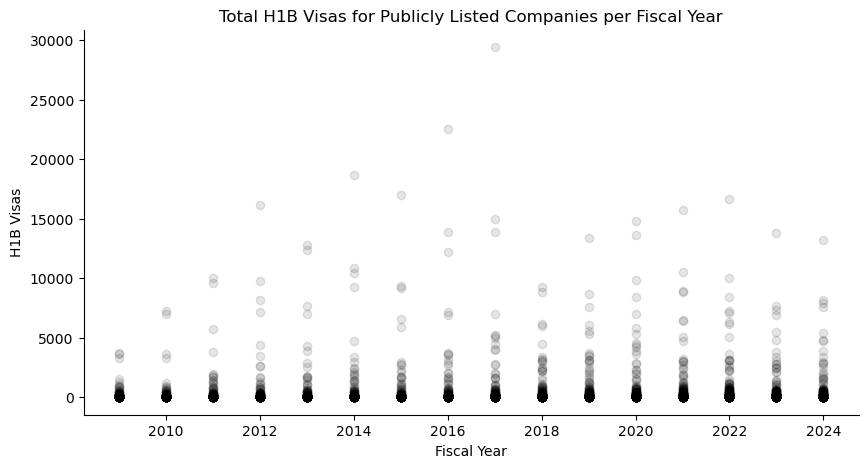

In [16]:
fig, ax = plt.subplots(figsize=(10,5)) 
ax.scatter('Fiscal Year', 'tot_app' ,data = h1b_df, color='black', alpha = .1)  

ax.set_ylabel('H1B Visas')
ax.set_xlabel('Fiscal Year')
ax.set_title('Total H1B Visas for Publicly Listed Companies per Fiscal Year')
sns.despine(ax=ax)

plt.show()

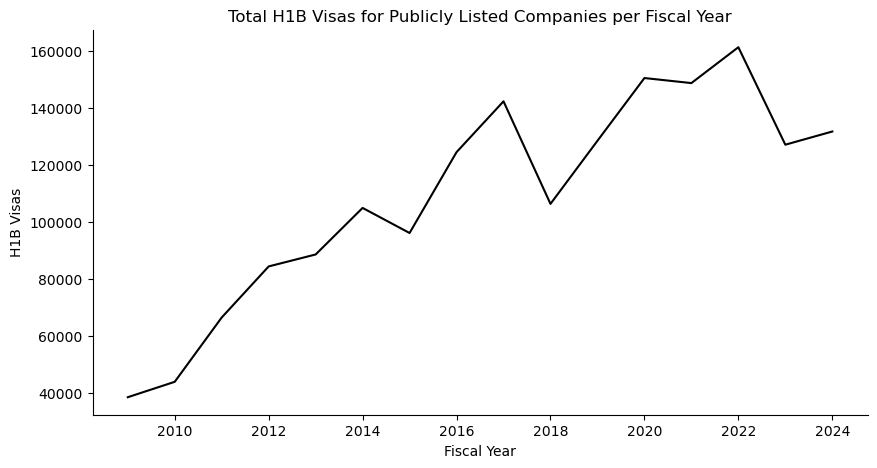

In [17]:
year_sums = h1b_df.groupby('Fiscal Year').sum().loc[:, ['tot_app']].reset_index()
fig, ax = plt.subplots(figsize=(10,5)) 

ax.plot('Fiscal Year', 'tot_app' ,data = year_sums, color='black')  
ax.set_ylabel('H1B Visas')
ax.set_xlabel('Fiscal Year')
ax.set_title('Total H1B Visas for Publicly Listed Companies per Fiscal Year')
sns.despine(ax=ax)

plt.show()


In [18]:
#Run once to have data locally
voo_data = yf.download('VOO', start="2008-01-01", end="2025-01-01", progress = False, interval='1wk')
#voo_data.to_csv('data/voo_hist_data.csv')
#voo_data = pd.read_csv('data/voo_hist_data.csv')
voo_data.head()

YF.download() has changed argument auto_adjust default to True


Price,Close,High,Low,Open,Volume
Ticker,VOO,VOO,VOO,VOO,VOO
Date,,,,,
2010-09-06,77.804466,78.354862,77.315227,78.354862,35100
2010-09-13,79.012230,79.409735,78.263079,78.706454,211300
2010-09-20,80.143669,80.602337,78.828841,79.302789,113800
2010-09-27,80.486641,81.224486,79.487473,80.686476,142600
2010-10-04,81.993111,82.039224,79.548996,80.901715,496900


In [19]:
voo_data['year'] = voo_data.index.year
yearly_voo = voo_data.groupby('year').mean().droplevel('Ticker', axis=1)
yearly_voo.head()

Price,Close,High,Low,Open,Volume
year,,,,,
2010,83.894025,84.346592,82.488775,83.438488,2.457647e+05
2011,90.351376,91.944941,88.499465,90.294930,1.089531e+06
2012,100.639404,101.689036,99.149785,100.294882,1.978665e+06
2013,123.059824,123.885117,121.346612,122.589880,4.896577e+06
2014,147.051349,148.269502,145.189701,146.769963,6.308038e+06


In [20]:
yearly_voo['vol_change'] = yearly_voo['Volume'].pct_change()
yearly_voo['open_change'] = yearly_voo['Open'].pct_change()
yearly_voo['close_change'] = yearly_voo['Close'].pct_change()
yearly_voo.head()

Price,Close,High,Low,Open,Volume,vol_change,open_change,close_change
year,,,,,,,,
2010,83.894025,84.346592,82.488775,83.438488,2.457647e+05,NaN,NaN,NaN
2011,90.351376,91.944941,88.499465,90.294930,1.089531e+06,3.433227,0.082174,0.076970
2012,100.639404,101.689036,99.149785,100.294882,1.978665e+06,0.816071,0.110748,0.113867
2013,123.059824,123.885117,121.346612,122.589880,4.896577e+06,1.474687,0.222294,0.222780
2014,147.051349,148.269502,145.189701,146.769963,6.308038e+06,0.288255,0.197244,0.194958


In [21]:
year_sums['chng'] = year_sums['tot_app'].pct_change()
year_sums.head(2)

,Fiscal Year,tot_app,chng
0,2009,38448,<NA>
1,2010,43857,0.140684


In [22]:
combined = yearly_voo.merge(year_sums, left_on='year', right_on='Fiscal Year')
combined.head(2)

,Close,High,Low,Open,Volume,vol_change,open_change,close_change,Fiscal Year,tot_app,chng
0,83.894025,84.346592,82.488775,83.438488,2.457647e+05,NaN,NaN,NaN,2010,43857,0.140684
1,90.351376,91.944941,88.499465,90.294930,1.089531e+06,3.433227,0.082174,0.07697,2011,66420,0.514467


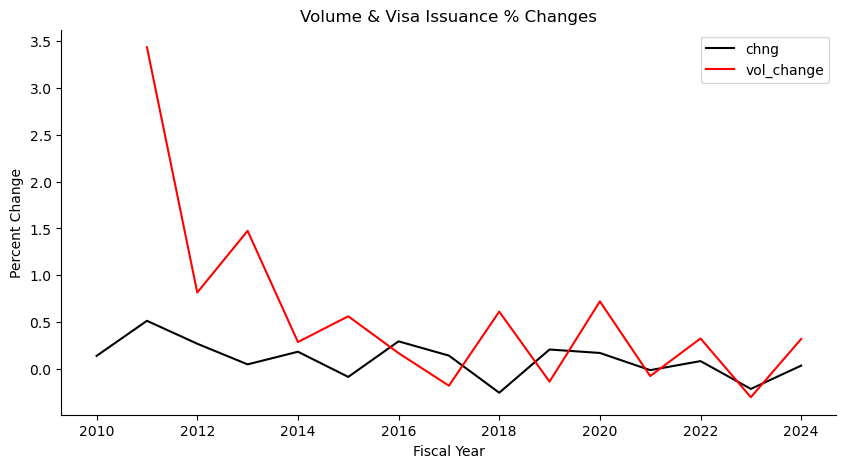

In [23]:

fig, ax = plt.subplots(figsize=(10,5)) 

ax.plot('Fiscal Year', 'chng' ,data = combined, color='black')  
ax.plot('Fiscal Year', 'vol_change' ,data = combined, color='red') 
ax.set_ylabel('Percent Change')
ax.set_xlabel('Fiscal Year')
ax.set_title('Volume & Visa Issuance % Changes')
ax.legend()
sns.despine(ax=ax)

plt.show()

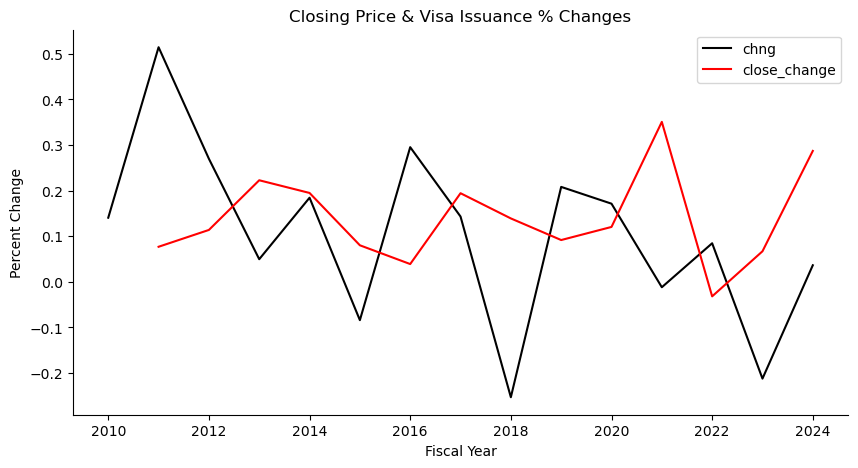

In [24]:

fig, ax = plt.subplots(figsize=(10,5)) 

ax.plot('Fiscal Year', 'chng' ,data = combined, color='black')  
ax.plot('Fiscal Year', 'close_change' ,data = combined, color='red') 
ax.set_ylabel('Percent Change')
ax.set_xlabel('Fiscal Year')
ax.set_title('Closing Price & Visa Issuance % Changes')
ax.legend()
sns.despine(ax=ax)

plt.show()

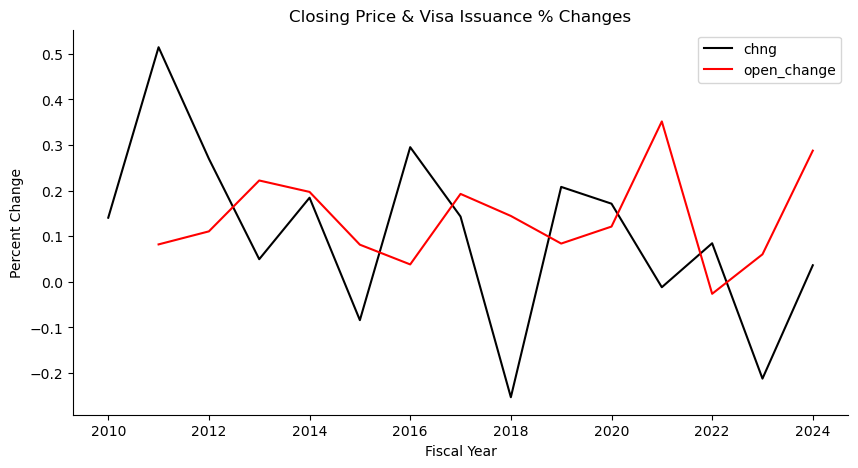

In [25]:

fig, ax = plt.subplots(figsize=(10,5)) 

ax.plot('Fiscal Year', 'chng' ,data = combined, color='black')  
ax.plot('Fiscal Year', 'open_change' ,data = combined, color='red') 
ax.set_ylabel('Percent Change')
ax.set_xlabel('Fiscal Year')
ax.set_title('Closing Price & Visa Issuance % Changes')
ax.legend()
sns.despine(ax=ax)

plt.show()

In [26]:
import time
def fetch_stock_info(tickers):
    #all_data = {}
    infor = {}
    dict_list = []
    print('Downloading yfinance information on select tickers...')
    for ticker in tickers:
        try:
            infor[ticker] = yf.Ticker(ticker).info
            time.sleep(2.001)  # Sleep for 2 seconds between requests to avoid being blocked

        except Exception as e:
            print(f"Error downloading {ticker}: {e}")
            time.sleep(2.001)
    return pd.DataFrame(infor)

In [27]:
#company_info_df = fetch_stock_info(h1b_df['ticker'].unique())
#company_info_df.to_csv('company_info_df.csv')

In [28]:
company_info_df = pd.read_csv('company_info_df.csv').T
company_info_df = company_info_df.rename(columns=company_info_df.iloc[0]).drop(company_info_df.index[0])
company_info_df.head()

,address1,city,state,zip,country,phone,fax,website,industry,industryKey,...,fundFamily,fundInceptionDate,legalType,threeYearAverageReturn,trailingThreeMonthReturns,trailingThreeMonthNavReturns,netAssets,netExpenseRatio,fiveYearAverageReturn,newSymbol
A,5301 Stevens Creek Boulevard,Santa Clara,CA,95051,United States,800 227 9770,866 497 1134,https://www.agilent.com,Diagnostics & Research,diagnostics-research,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AA,201 Isabella Street,Pittsburgh,PA,15212-5858,United States,412 315 2900,NaN,https://www.alcoa.com,Aluminum,aluminum,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AAL,1 Skyview Drive,Fort Worth,TX,76155,United States,682 278 9000,NaN,https://www.aa.com,Airlines,airlines,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AAMI,200 Clarendon Street,Boston,MA,02116,United States,617-369-7300,NaN,https://www.bsig.com,Asset Management,asset-management,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AAOI,13139 Jess Pirtle Boulevard,Sugar Land,TX,77478,United States,(281) 295-1800,NaN,https://www.ao-inc.com,Communication Equipment,communication-equipment,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [29]:
drop_cols_2 = []
for x in company_info_df.columns:
    if x in ["sector", "auditRisk", "boardRisk", "overallRisk", "totalAssets"]:
        continue
    if len(company_info_df[x].unique()) < 20:
        drop_cols_2.append(x)

print(drop_cols_2) 

['sectorKey', 'sectorDisp', 'compensationRisk', 'shareHolderRightsRisk', 'governanceEpochDate', 'compensationAsOfEpochDate', 'executiveTeam', 'maxAge', 'priceHint', 'currency', 'tradeable', 'SandP52WeekChange', 'quoteType', 'recommendationKey', 'language', 'region', 'typeDisp', 'quoteSourceName', 'triggerable', 'customPriceAlertConfidence', 'exchange', 'exchangeTimezoneName', 'exchangeTimezoneShortName', 'gmtOffSetMilliseconds', 'market', 'esgPopulated', 'marketState', 'hasPrePostMarketData', 'isEarningsDateEstimate', 'sourceInterval', 'exchangeDataDelayedBy', 'fullExchangeName', 'cryptoTradeable', 'nameChangeDate', 'industrySymbol', 'yield', 'navPrice', 'category', 'ytdReturn', 'beta3Year', 'fundFamily', 'fundInceptionDate', 'legalType', 'threeYearAverageReturn', 'trailingThreeMonthReturns', 'trailingThreeMonthNavReturns', 'netAssets', 'netExpenseRatio', 'fiveYearAverageReturn', 'newSymbol']


In [30]:
company_info_df = company_info_df.drop(drop_cols_2, axis = 1)
company_info_df.head()

,address1,city,state,zip,country,phone,fax,website,industry,industryKey,...,averageAnalystRating,firstTradeDateMilliseconds,regularMarketChange,regularMarketDayRange,displayName,trailingPegRatio,address2,prevName,ipoExpectedDate,totalAssets
A,5301 Stevens Creek Boulevard,Santa Clara,CA,95051,United States,800 227 9770,866 497 1134,https://www.agilent.com,Diagnostics & Research,diagnostics-research,...,2.1 - Buy,942935400000,0.98000336,103.16 - 106.0,Agilent,1.7168,NaN,NaN,NaN,NaN
AA,201 Isabella Street,Pittsburgh,PA,15212-5858,United States,412 315 2900,NaN,https://www.alcoa.com,Aluminum,aluminum,...,1.7 - Buy,-252322200000,1.1750011,25.28 - 26.24,Alcoa,NaN,Suite 500,NaN,NaN,NaN
AAL,1 Skyview Drive,Fort Worth,TX,76155,United States,682 278 9000,NaN,https://www.aa.com,Airlines,airlines,...,2.1 - Buy,1127827800000,0.16989994,9.21 - 9.68,American Airlines,0.2903,NaN,NaN,NaN,NaN
AAMI,200 Clarendon Street,Boston,MA,02116,United States,617-369-7300,NaN,https://www.bsig.com,Asset Management,asset-management,...,3.0 - Hold,1412861400000,0.34000015,26.2151 - 26.89,Acadian Asset Management,NaN,53rd Floor,BrightSphere Investment Group Inc.,NaN,NaN
AAOI,13139 Jess Pirtle Boulevard,Sugar Land,TX,77478,United States,(281) 295-1800,NaN,https://www.ao-inc.com,Communication Equipment,communication-equipment,...,1.8 - Buy,1380202200000,0.70440006,11.535 - 12.59,Applied Optoelectronics,NaN,NaN,NaN,NaN,NaN


In [31]:
company_info_df.to_csv("company_info_df_clean.csv")


In [32]:
company_info_df = pd.read_csv("company_info_df_clean.csv")

In [33]:
h1b_2024 = h1b_df[h1b_df['Fiscal Year'] == 2024]
h1b_2024.head()

,Fiscal Year,ticker,employer,Tax ID,Industry (NAICS) Code,Petitioner City,Petitioner State,Petitioner Zip Code,Initial Approval,Continuing Approval,type,tot_app
18990,2024,A,AGILENT,8772,31-33 - Manufacturing,SANTA CLARA,CA,95052,11,24,h1b,35
18991,2024,AA,ALCOA,9115,31-33 - Manufacturing,PITTSBURGH,PA,15212,1,2,h1b,3
18992,2024,AAL,AMERICAN AIRLINES,2798,48-49 - Transportation and Warehousing,FORT WORTH,TX,76155,43,228,h1b,271
18993,2024,AAMI,ACADIAN ASSET,9221,52 - Finance and Insurance,BOSTON,MA,2110,4,4,h1b,8
18994,2024,AAOI,APPLIED OPTOELECTRONICS,3927,31-33 - Manufacturing,SUGAR LAND,TX,77478,4,6,h1b,10


In [34]:
visa_and_info_df = company_info_df.merge(h1b_2024, how = 'inner', left_on='symbol', right_on='ticker')
visa_and_info_df.head()

,Unnamed: 0,address1,city,state,zip,country,phone,fax,website,industry,...,employer,Tax ID,Industry (NAICS) Code,Petitioner City,Petitioner State,Petitioner Zip Code,Initial Approval,Continuing Approval,type,tot_app
0,A,5301 Stevens Creek Boulevard,Santa Clara,CA,95051,United States,800 227 9770,866 497 1134,https://www.agilent.com,Diagnostics & Research,...,AGILENT,8772,31-33 - Manufacturing,SANTA CLARA,CA,95052,11,24,h1b,35
1,AA,201 Isabella Street,Pittsburgh,PA,15212-5858,United States,412 315 2900,NaN,https://www.alcoa.com,Aluminum,...,ALCOA,9115,31-33 - Manufacturing,PITTSBURGH,PA,15212,1,2,h1b,3
2,AAL,1 Skyview Drive,Fort Worth,TX,76155,United States,682 278 9000,NaN,https://www.aa.com,Airlines,...,AMERICAN AIRLINES,2798,48-49 - Transportation and Warehousing,FORT WORTH,TX,76155,43,228,h1b,271
3,AAMI,200 Clarendon Street,Boston,MA,02116,United States,617-369-7300,NaN,https://www.bsig.com,Asset Management,...,ACADIAN ASSET,9221,52 - Finance and Insurance,BOSTON,MA,2110,4,4,h1b,8
4,AAOI,13139 Jess Pirtle Boulevard,Sugar Land,TX,77478,United States,(281) 295-1800,NaN,https://www.ao-inc.com,Communication Equipment,...,APPLIED OPTOELECTRONICS,3927,31-33 - Manufacturing,SUGAR LAND,TX,77478,4,6,h1b,10


In [35]:
visa_and_info_df.groupby('industry').sum()['tot_app']

industry
Advertising Agencies              116
Aerospace & Defense               201
Agricultural Inputs                27
Airlines                          499
Aluminum                            5
                                 ... 
Utilities - Regulated Electric    103
Utilities - Regulated Gas          27
Utilities - Regulated Water         3
Utilities - Renewable              58
Waste Management                   36
Name: tot_app, Length: 132, dtype: Int64

In [36]:
visa_and_info_df.groupby('sector').sum()['tot_app']

sector
Basic Materials             485
Communication Services    13476
Consumer Cyclical         20994
Consumer Defensive         4057
Energy                      274
Financial Services         7998
Healthcare                 5944
Industrials                4993
Real Estate                 444
Technology                58882
Utilities                   235
Name: tot_app, dtype: Int64

In [37]:
visa_and_info_df.groupby('city').sum()['tot_app']

city
Acton             34
Addison            1
Admiralty          6
Alachua            1
Alameda           52
                  ..
Woodcliff Lake     2
Woodland Hills    20
Worcester          6
Zeeland            6
Zurich            48
Name: tot_app, Length: 553, dtype: Int64

In [38]:
visa_and_info_df.groupby('state').sum()['tot_app']

state
AB        80
AL         8
AR      3429
AZ       642
BC        34
CA     37707
CO       363
CT       623
DC        89
DE        40
FL      1045
GA      1124
IA        41
ID       374
IL      1424
IN      1497
KS         4
KY       250
LA        33
MA      1981
MD       228
ME        11
MG         2
MI      1622
MN       410
MO       236
MS         2
MT       307
NC      1581
NE        42
NF         1
NH        21
NJ      8392
NM         4
NSW      166
NV        86
NY      8599
OH       566
OK        19
ON       187
OR       328
PA       838
QC        25
RI         2
SC        27
SP        18
TN       363
TX      4183
UT       160
VA      1010
WA     19259
WI       558
WV         2
Name: tot_app, dtype: Int64

In [39]:
visa_and_info_df.groupby('zip').sum()['tot_app']

zip
01310-100    13
01532         8
01653         6
01701        14
01720        34
             ..
WA14 2DT      1
WC1A 1DG     13
WC2R 0RL      1
WD18 8YE     30
WIS 4PZ       2
Name: tot_app, Length: 993, dtype: Int64

In [40]:
visa_and_info_df.groupby('Industry (NAICS) Code').sum()['tot_app']

Industry (NAICS) Code
11 - Agriculture, Forestry, Fishing and Hunting                                      1
21 - Mining, Quarrying, and Oil and Gas Extraction                                 192
22 - Utilities                                                                     266
23 - Construction                                                                  181
31-33 - Manufacturing                                                            24282
42 - Wholesale Trade                                                               526
44-45 - Retail Trade                                                             19863
48-49 - Transportation and Warehousing                                             829
51 - Information                                                                 15771
52 - Finance and Insurance                                                        6390
53 - Real Estate and Rental and Leasing                                            400
54 - Professional, Sc

In [41]:
def remove_outliers_iqr(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

    return df

fullTimeEmployees


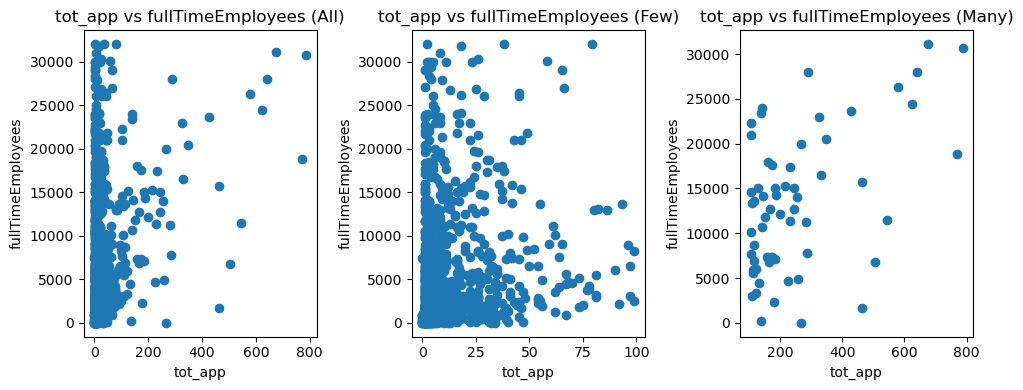

auditRisk


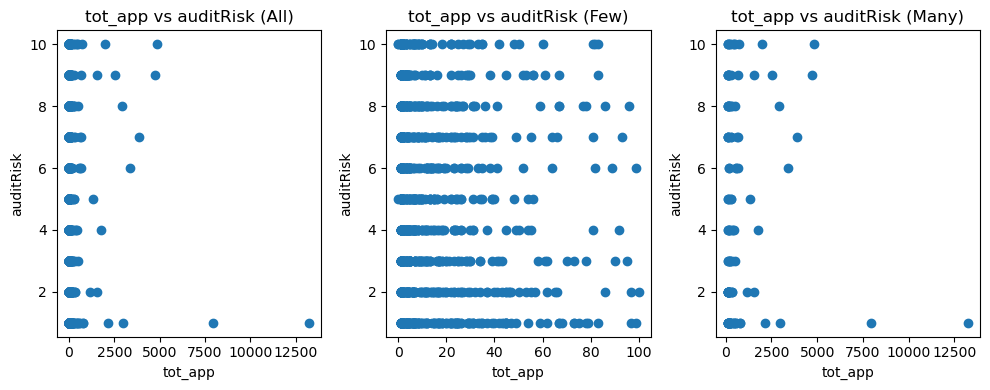

beta


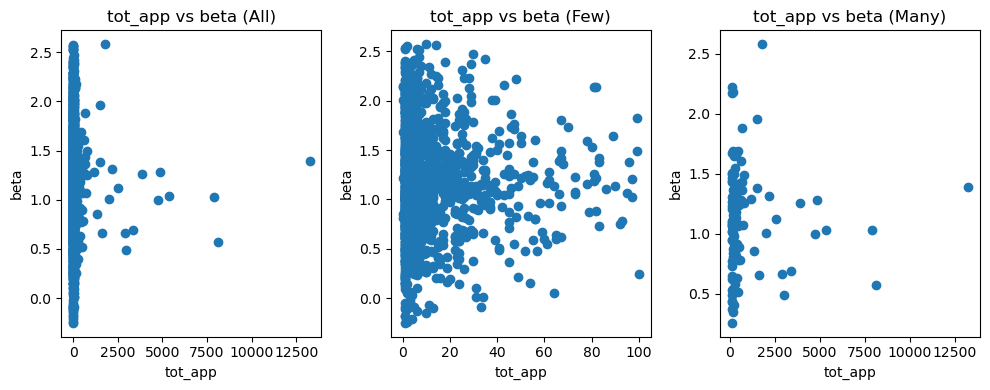

forwardPE


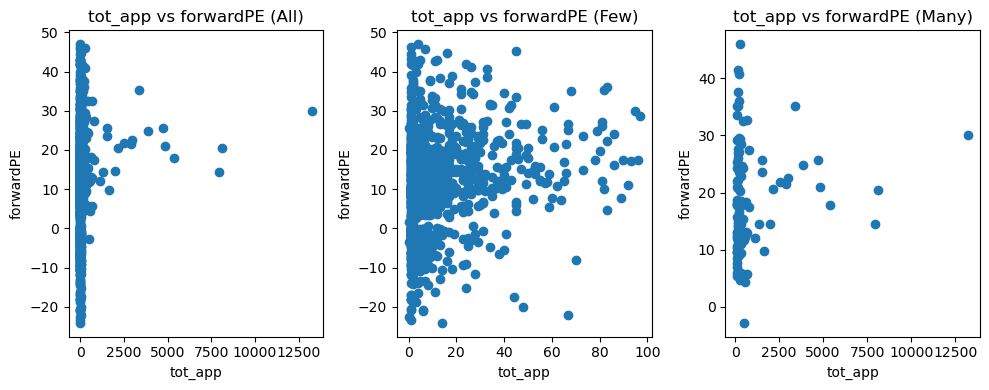

profitMargins


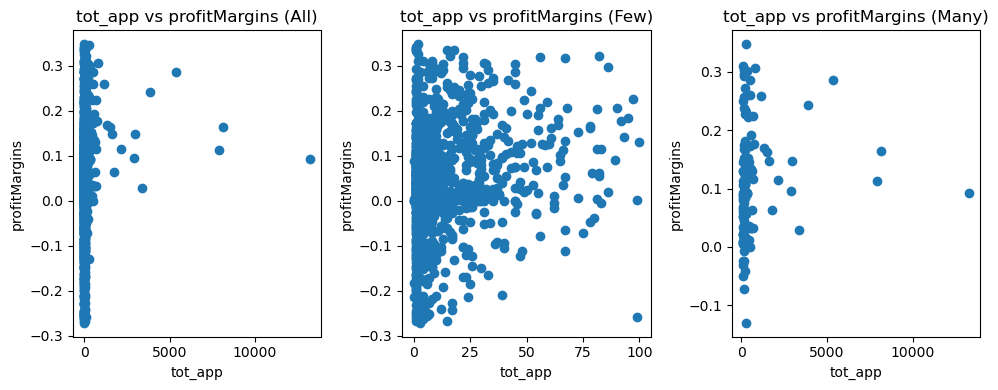

sharesPercentSharesOut


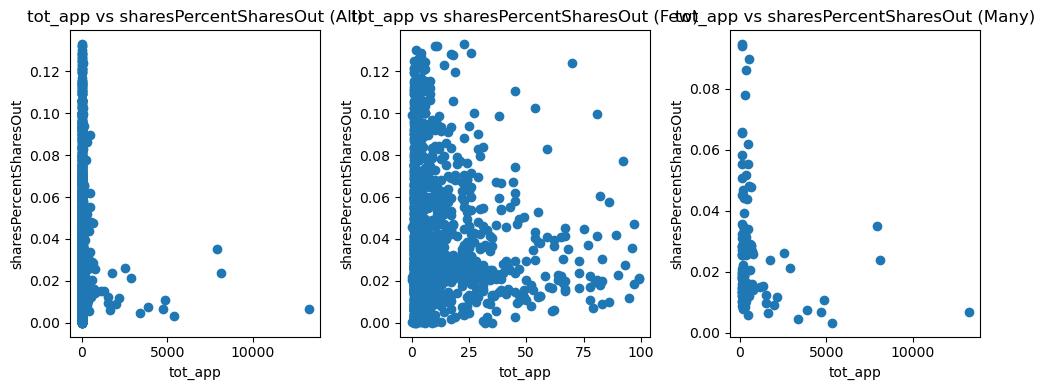

heldPercentInstitutions


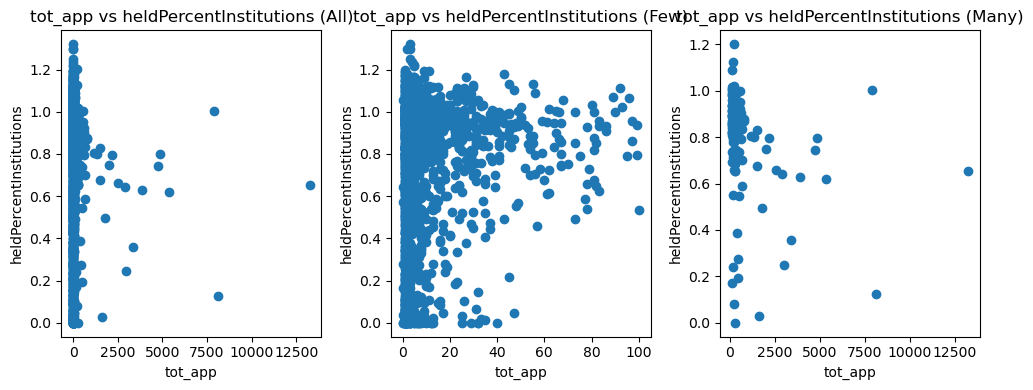

shortRatio


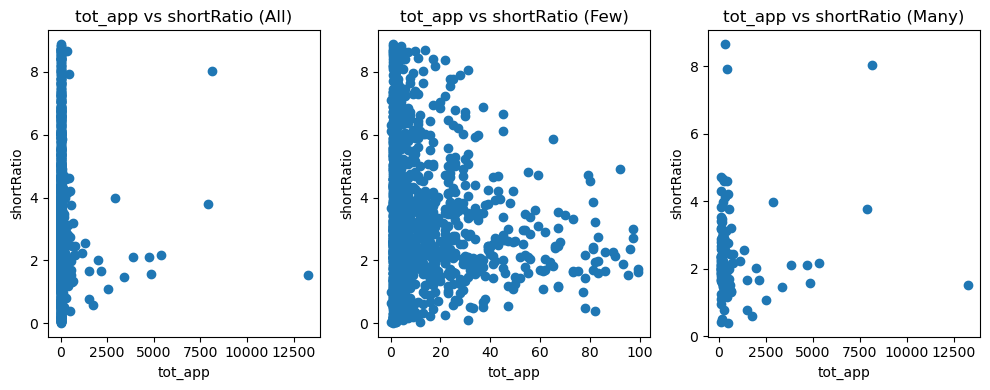

priceToBook


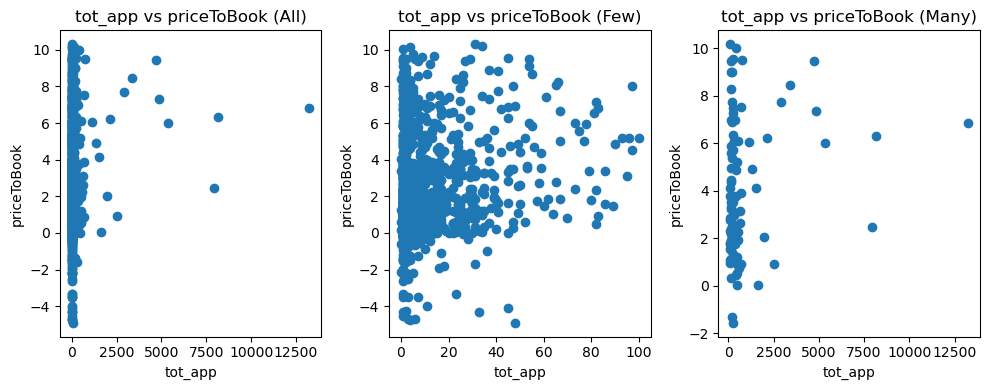

earningsQuarterlyGrowth


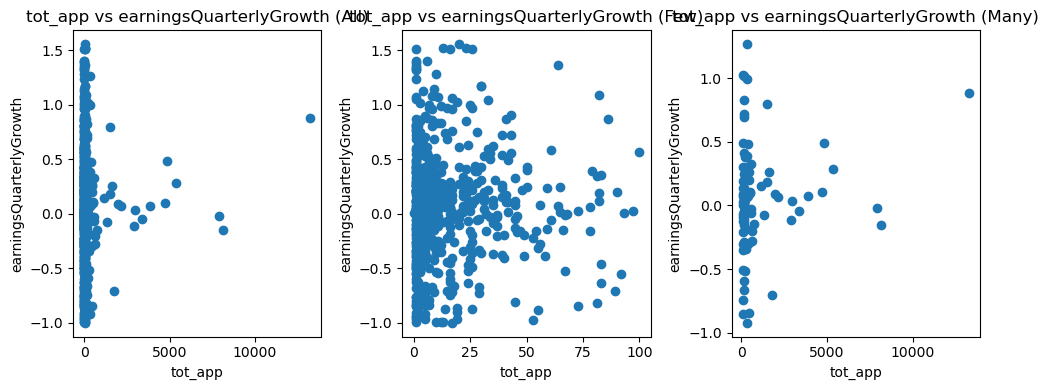

52WeekChange


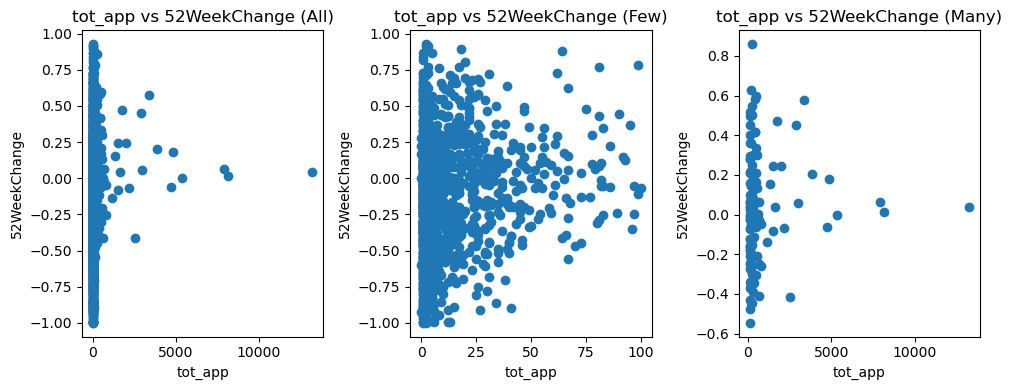

returnOnAssets


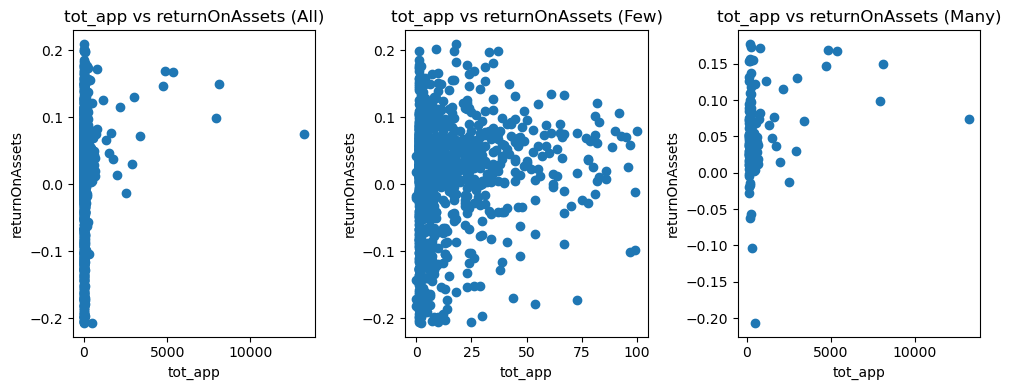

returnOnEquity


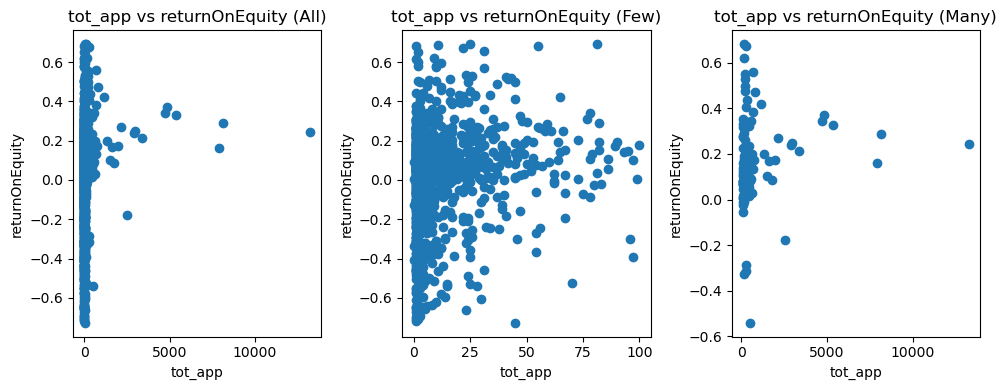

revenueGrowth


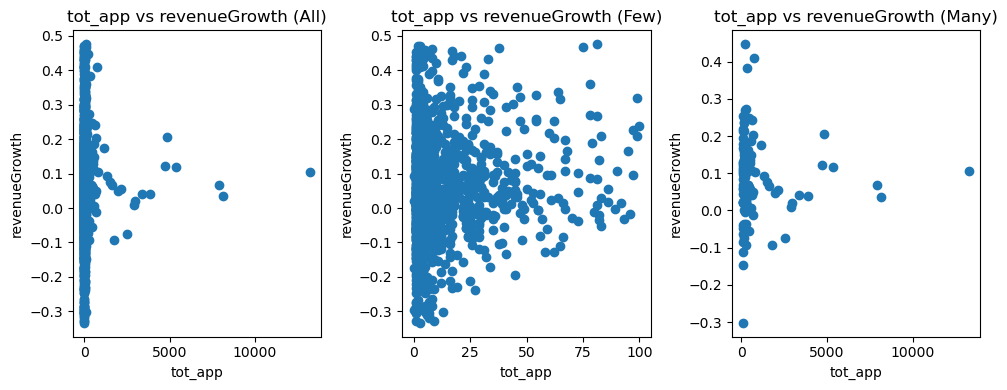

fiftyTwoWeekChangePercent


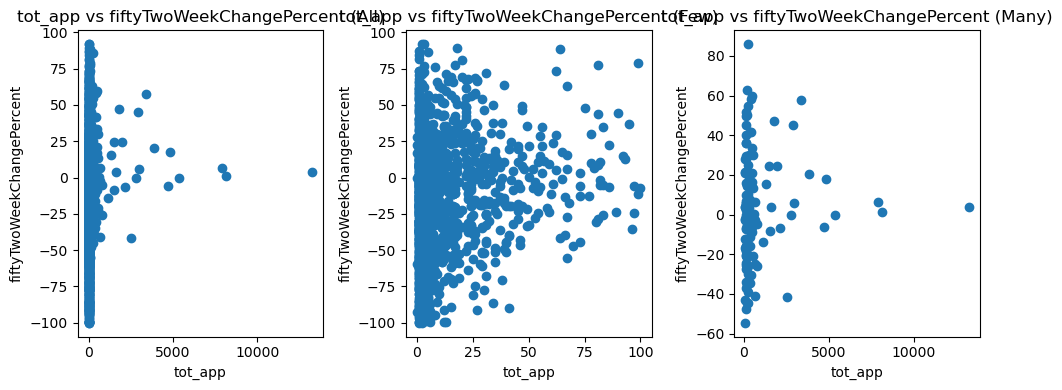

fiftyDayAverageChangePercent


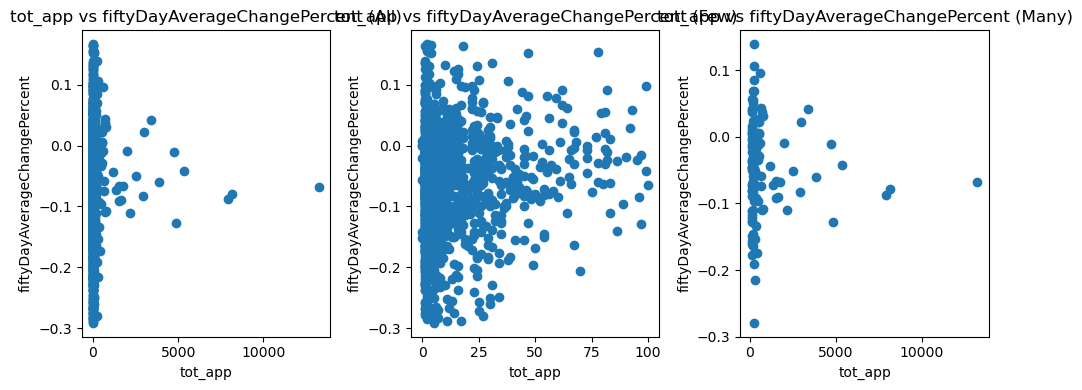

twoHundredDayAverageChangePercent


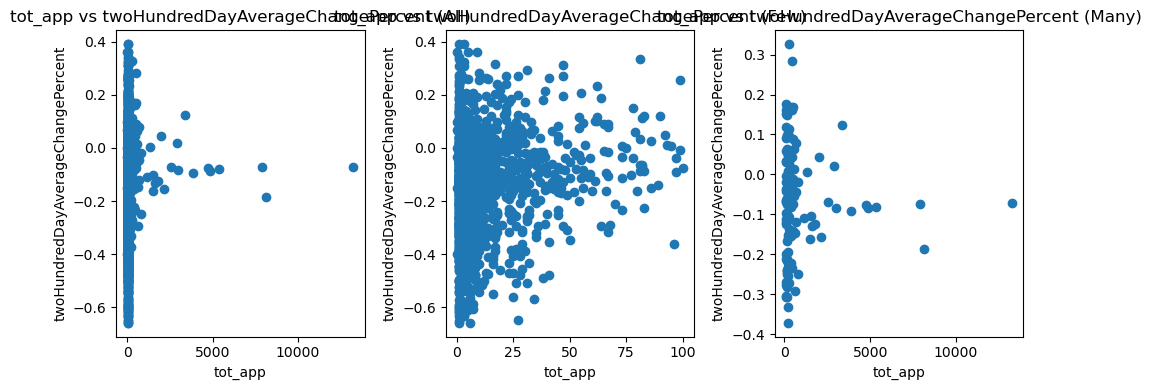

In [111]:
target_col = 'tot_app'
graphs_with_patterns = ['fullTimeEmployees', 'auditRisk', 'beta', 'forwardPE', 'profitMargins', 'sharesPercentSharesOut', 
                        'heldPercentInstitutions', 'shortRatio', 'priceToBook', 'earningsQuarterlyGrowth', '52WeekChange', 
                        'returnOnAssets', 'returnOnEquity', 'revenueGrowth', 'fiftyTwoWeekChangePercent', 'fiftyDayAverageChangePercent', 'twoHundredDayAverageChangePercent']

for col in graphs_with_patterns:
        if col != target_col:
            print(col)
            data = remove_outliers_iqr(visa_and_info_df, col)
            few_visas = data[data['tot_app'] <= 100]
            many_visas = data[data['tot_app'] > 100]

            fig, axs = plt.subplots(1, 3, figsize=(10, 4))

            axs[0].scatter(data[target_col], data[col])
            axs[0].set_title(f'{target_col} vs {col} (All)')
            axs[0].set_xlabel(target_col)
            axs[0].set_ylabel(col)

            axs[1].scatter(few_visas[target_col], few_visas[col])
            axs[1].set_title(f'{target_col} vs {col} (Few)')
            axs[1].set_xlabel(target_col)
            axs[1].set_ylabel(col)

            
            axs[2].scatter(many_visas[target_col], many_visas[col])
            axs[2].set_title(f'{target_col} vs {col} (Many)')
            axs[2].set_xlabel(target_col)
            axs[2].set_ylabel(col)

            # Adjust layout and show
            plt.tight_layout()
            plt.show()

In [ ]:
companies = [entry["ticker"] for entry in data.values()]
no_visas = []

for c in companies:
    if c not in visa_and_info_df['symbol'].values:
        no_visas.append(c)

1574
8142


In [79]:
import random
random.seed(10)
sampled_no_visas = random.sample(no_visas, 1574)

no_visa_info = fetch_stock_info(sampled_no_visas)
no_visa_info.to_csv("no_visa_info.csv")

Error downloading ADZCF: list index out of range


404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/HYB?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=HYB&crumb=xVjYl%2Fi4nq%2F


Error downloading HYB: 'NoneType' object has no attribute 'update'


404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/IZTC?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=IZTC&crumb=xVjYl%2Fi4nq%2F


Error downloading IZTC: 'NoneType' object has no attribute 'update'
Error downloading AADI: list index out of range
Error downloading DNMRW: list index out of range
Error downloading KRBP: list index out of range
Error downloading YTTA: list index out of range
Error downloading BHIL: list index out of range
Error downloading MSGY: list index out of range


404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/EZFL?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=EZFL&crumb=xVjYl%2Fi4nq%2F


Error downloading EZFL: 'NoneType' object has no attribute 'update'
Error downloading ADMWF: list index out of range
Error downloading AURN: list index out of range
Error downloading TCBPW: list index out of range
Error downloading AAGO: list index out of range
Error downloading GMCG: list index out of range
Error downloading WDCVV: list index out of range
Error downloading SPHAR: list index out of range


404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/GSHR?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=GSHR&crumb=xVjYl%2Fi4nq%2F


Error downloading GSHR: 'NoneType' object has no attribute 'update'
Error downloading DM: list index out of range
Error downloading SPAZF: list index out of range
Error downloading YY: list index out of range
Error downloading ALVR: list index out of range
Error downloading CJJD: list index out of range
Error downloading PMVC: list index out of range
Error downloading AURS: list index out of range


404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/ZUO?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=ZUO&crumb=xVjYl%2Fi4nq%2F


Error downloading ZUO: 'NoneType' object has no attribute 'update'
Error downloading FREY: list index out of range


404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/NRO-RI?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=NRO-RI&crumb=xVjYl%2Fi4nq%2F


Error downloading NRO-RI: 'NoneType' object has no attribute 'update'
Error downloading AHMA: list index out of range
Error downloading NXU: list index out of range


404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/SILV?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=SILV&crumb=xVjYl%2Fi4nq%2F


Error downloading SILV: 'NoneType' object has no attribute 'update'


404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/LFS?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=LFS&crumb=xVjYl%2Fi4nq%2F


Error downloading LFS: 'NoneType' object has no attribute 'update'


404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/TREO?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=TREO&crumb=xVjYl%2Fi4nq%2F


Error downloading TREO: 'NoneType' object has no attribute 'update'


500 Server Error: Internal Server Error for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/DMYY-WT?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=DMYY-WT&crumb=xVjYl%2Fi4nq%2F


Error downloading DMYY-WT: 'NoneType' object has no attribute 'update'
Error downloading FEMFF: list index out of range


404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/LAWR?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=LAWR&crumb=xVjYl%2Fi4nq%2F


Error downloading LAWR: 'NoneType' object has no attribute 'update'
Error downloading SBT: list index out of range
Error downloading INFN: list index out of range
Error downloading ALIV: list index out of range
Error downloading SCAG: list index out of range
Error downloading SPHA: list index out of range


404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/MYNA?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=MYNA&crumb=xVjYl%2Fi4nq%2F


Error downloading MYNA: 'NoneType' object has no attribute 'update'
Error downloading MSSAU: list index out of range
Error downloading NVRO: list index out of range
Error downloading ODRS: list index out of range


In [138]:
no_visa_info_df = pd.read_csv('no_visa_info.csv').T
no_visa_info_df = no_visa_info_df.rename(columns=no_visa_info_df.iloc[0]).drop(no_visa_info_df.index[0]).reset_index()
no_visa_info_df['visa'] = 0
no_visa_info.rename(columns={'index': 'Unnamed: 0'}, inplace=True)
no_visa_info_df.head()

,index,address1,address2,city,state,zip,country,phone,website,industry,...,netAssets,netExpenseRatio,postMarketTime,postMarketChangePercent,postMarketPrice,postMarketChange,prevExchange,exchangeTransferDate,newListingDate,visa
0,JAGX,200 Pine Street,Suite 400,San Francisco,CA,94104,United States,415 371 8300,https://jaguar.health,Biotechnology,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,RKT,1050 Woodward Avenue,NaN,Detroit,MI,48226,United States,313 373 7990,https://www.rocketcompanies.com,Mortgage Finance,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,SRTS,851 Broken Sound Parkway NW,Suite 215,Boca Raton,FL,33487,United States,561 922 5808,https://sensushealthcare.com,Medical Devices,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,ANGH,"Al-Khatem Tower, WeWork Hub 71",16th Floor Abu Dhabi Global Market Square Al M...,Abu Dhabi,NaN,NaN,United Arab Emirates,NaN,https://www.anghami.com,Entertainment,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,EVGN,13 Gad Feinstein Street,Park Rehovot,Rehovot,NaN,7638517,Israel,972 8 931 1900,https://www.evogene.com,Biotechnology,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [139]:
company_info_df['visa'] = 1
company_info_df.rename(columns={'Unnamed: 0': 'index'}, inplace=True)
company_info_df.head()

,index,address1,city,state,zip,country,phone,fax,website,industry,...,firstTradeDateMilliseconds,regularMarketChange,regularMarketDayRange,displayName,trailingPegRatio,address2,prevName,ipoExpectedDate,totalAssets,visa
0,A,5301 Stevens Creek Boulevard,Santa Clara,CA,95051,United States,800 227 9770,866 497 1134,https://www.agilent.com,Diagnostics & Research,...,9.429354e+11,0.980003,103.16 - 106.0,Agilent,1.7168,NaN,NaN,NaN,NaN,1
1,AA,201 Isabella Street,Pittsburgh,PA,15212-5858,United States,412 315 2900,NaN,https://www.alcoa.com,Aluminum,...,-2.523222e+11,1.175001,25.28 - 26.24,Alcoa,NaN,Suite 500,NaN,NaN,NaN,1
2,AAL,1 Skyview Drive,Fort Worth,TX,76155,United States,682 278 9000,NaN,https://www.aa.com,Airlines,...,1.127828e+12,0.169900,9.21 - 9.68,American Airlines,0.2903,NaN,NaN,NaN,NaN,1
3,AAMI,200 Clarendon Street,Boston,MA,02116,United States,617-369-7300,NaN,https://www.bsig.com,Asset Management,...,1.412861e+12,0.340000,26.2151 - 26.89,Acadian Asset Management,NaN,53rd Floor,BrightSphere Investment Group Inc.,NaN,NaN,1
4,AAOI,13139 Jess Pirtle Boulevard,Sugar Land,TX,77478,United States,(281) 295-1800,NaN,https://www.ao-inc.com,Communication Equipment,...,1.380202e+12,0.704400,11.535 - 12.59,Applied Optoelectronics,NaN,NaN,NaN,NaN,NaN,1


In [140]:
dummy_visas = pd.concat([no_visa_info_df, company_info_df])
dummy_visas.head()

,index,address1,address2,city,state,zip,country,phone,website,industry,...,netAssets,netExpenseRatio,postMarketTime,postMarketChangePercent,postMarketPrice,postMarketChange,prevExchange,exchangeTransferDate,newListingDate,visa
0,JAGX,200 Pine Street,Suite 400,San Francisco,CA,94104,United States,415 371 8300,https://jaguar.health,Biotechnology,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,RKT,1050 Woodward Avenue,NaN,Detroit,MI,48226,United States,313 373 7990,https://www.rocketcompanies.com,Mortgage Finance,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,SRTS,851 Broken Sound Parkway NW,Suite 215,Boca Raton,FL,33487,United States,561 922 5808,https://sensushealthcare.com,Medical Devices,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,ANGH,"Al-Khatem Tower, WeWork Hub 71",16th Floor Abu Dhabi Global Market Square Al M...,Abu Dhabi,NaN,NaN,United Arab Emirates,NaN,https://www.anghami.com,Entertainment,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,EVGN,13 Gad Feinstein Street,Park Rehovot,Rehovot,NaN,7638517,Israel,972 8 931 1900,https://www.evogene.com,Biotechnology,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [141]:
dummy_visas.set_index(dummy_visas.columns[0], inplace=True)

In [142]:
dummy_visas.head()

,address1,address2,city,state,zip,country,phone,website,industry,industryKey,...,netAssets,netExpenseRatio,postMarketTime,postMarketChangePercent,postMarketPrice,postMarketChange,prevExchange,exchangeTransferDate,newListingDate,visa
index,,,,,,,,,,,,,,,,,,,,,
JAGX,200 Pine Street,Suite 400,San Francisco,CA,94104,United States,415 371 8300,https://jaguar.health,Biotechnology,biotechnology,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
RKT,1050 Woodward Avenue,NaN,Detroit,MI,48226,United States,313 373 7990,https://www.rocketcompanies.com,Mortgage Finance,mortgage-finance,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
SRTS,851 Broken Sound Parkway NW,Suite 215,Boca Raton,FL,33487,United States,561 922 5808,https://sensushealthcare.com,Medical Devices,medical-devices,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
ANGH,"Al-Khatem Tower, WeWork Hub 71",16th Floor Abu Dhabi Global Market Square Al M...,Abu Dhabi,NaN,NaN,United Arab Emirates,NaN,https://www.anghami.com,Entertainment,entertainment,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
EVGN,13 Gad Feinstein Street,Park Rehovot,Rehovot,NaN,7638517,Israel,972 8 931 1900,https://www.evogene.com,Biotechnology,biotechnology,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [143]:
import numpy as np
dv_numerical = dummy_visas[dummy_visas['country'] == 'United States']#.select_dtypes(include=[np.number])

In [144]:
keep_cols = ['fullTimeEmployees', 'auditRisk', 'beta', 'forwardPE', 'profitMargins', 'sharesPercentSharesOut', 
                        'heldPercentInstitutions', 'shortRatio', 'priceToBook', 'earningsQuarterlyGrowth', '52WeekChange', 
                        'returnOnAssets', 'returnOnEquity', 'revenueGrowth', 'fiftyTwoWeekChangePercent', 'fiftyDayAverageChangePercent', 'twoHundredDayAverageChangePercent', 'visa']
dv_numericals = dv_numerical[keep_cols]
dv_numericals.head()

,fullTimeEmployees,auditRisk,beta,forwardPE,profitMargins,sharesPercentSharesOut,heldPercentInstitutions,shortRatio,priceToBook,earningsQuarterlyGrowth,52WeekChange,returnOnAssets,returnOnEquity,revenueGrowth,fiftyTwoWeekChangePercent,fiftyDayAverageChangePercent,twoHundredDayAverageChangePercent,visa
index,,,,,,,,,,,,,,,,,,
JAGX,49,NaN,1.115,-4.055556,0.0,0.077800006,0.016649999,1.44,0.7678079,NaN,-0.97014815,-0.36990002,-5.65739,0.526,-97.01482,-0.008228383,-0.6036984,0
RKT,14200,3,2.356,19.378788,0.00542,0.1744,0.7455,2.6,2.6584911,NaN,0.065587044,0.0325,0.07332,1.505,6.5587044,-0.048632085,-0.14762597,0
SRTS,54,NaN,1.115,8.146552,0.15899,0.0508,0.30152,6.71,3.0172412,4.224,0.37243402,0.08727,0.12701,1.557,37.2434,-0.017467272,-0.25000593,0
FCX,28500,6,1.708,17.268517,0.07111,0.0194,0.85643995,1.49,2.9523509,-0.256,-0.25485146,0.07496,0.14062001,-0.094,-25.485146,0.014866521,-0.107970305,0
AMAL,429,2,0.743,8.011494,0.34981,0.0511,0.64978,5.69,1.2083911,0.079,0.12642276,0.01312,0.16463,0.017,12.642277,-0.06284455,-0.13248438,0


In [162]:
dv_numericals = dv_numericals.loc[:, ~dv_numericals.columns.duplicated()].astype(float)

In [178]:
group_means = dv_numericals.groupby('visa').mean()

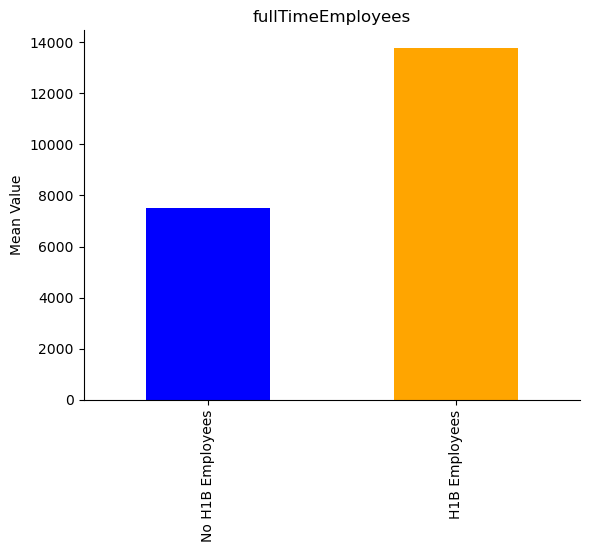

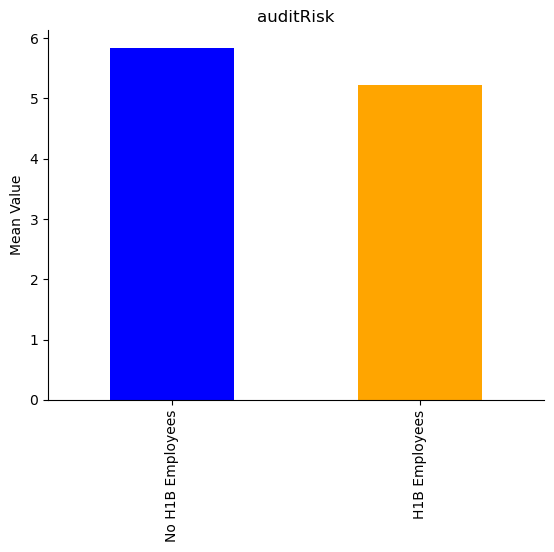

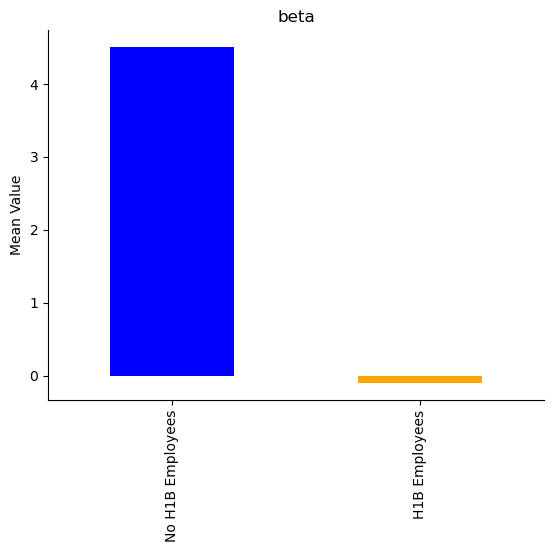

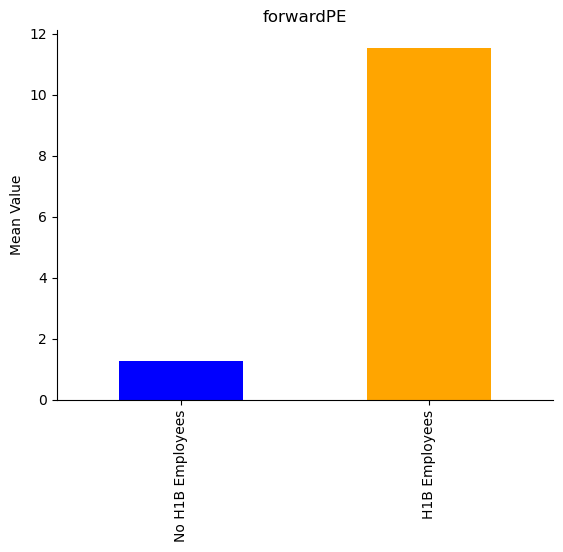

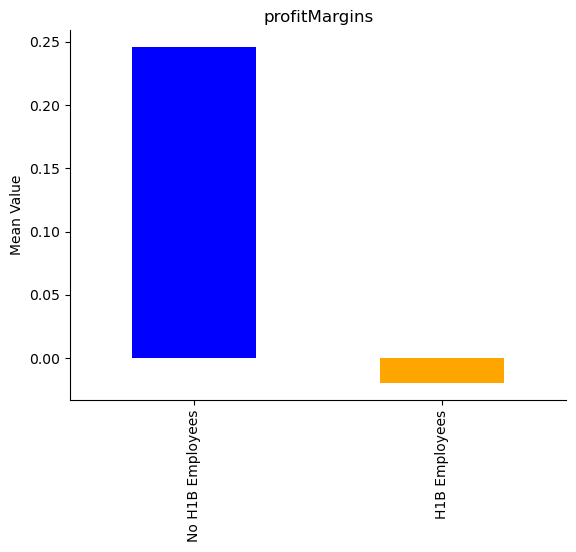

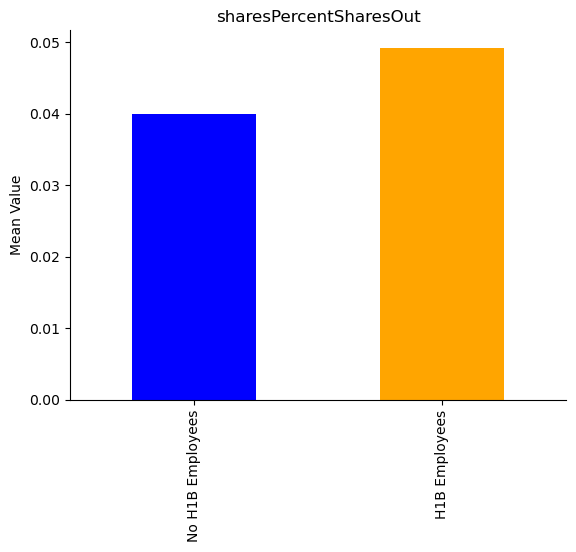

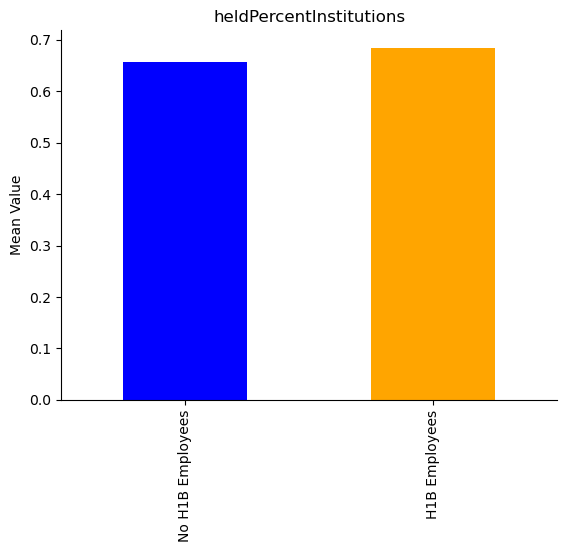

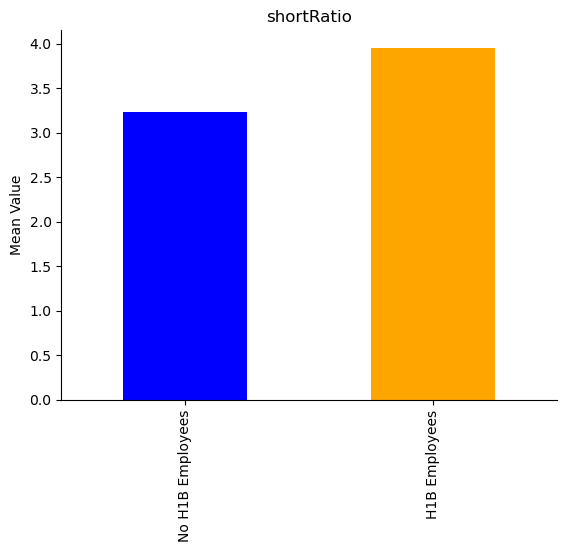

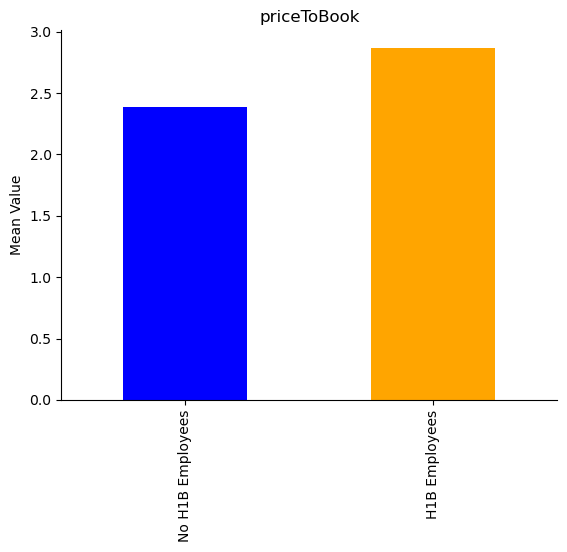

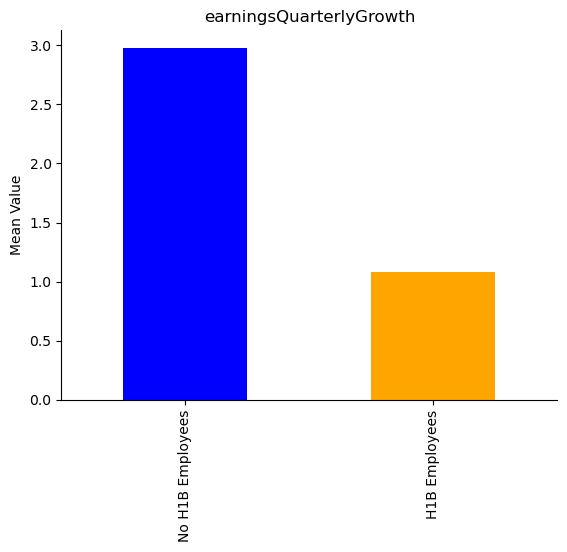

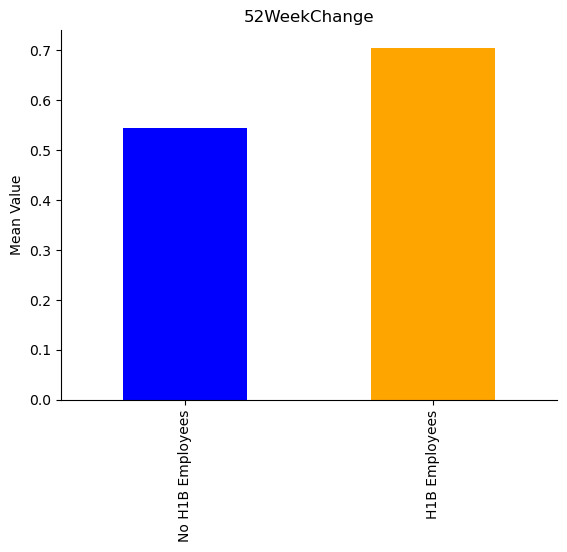

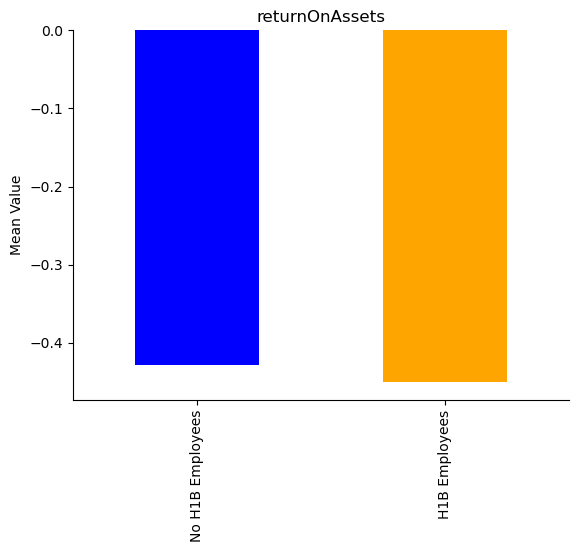

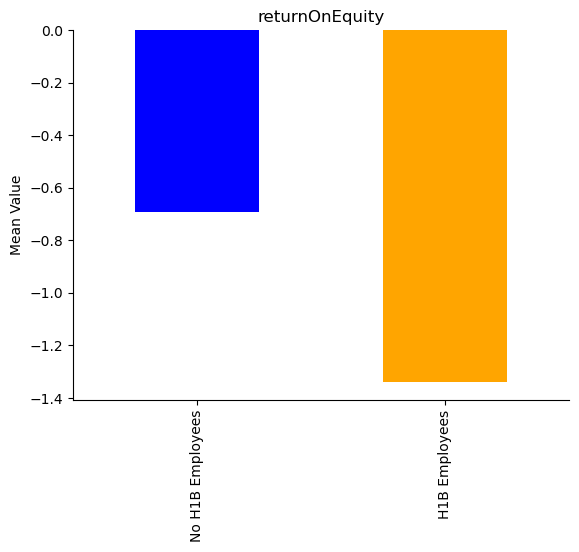

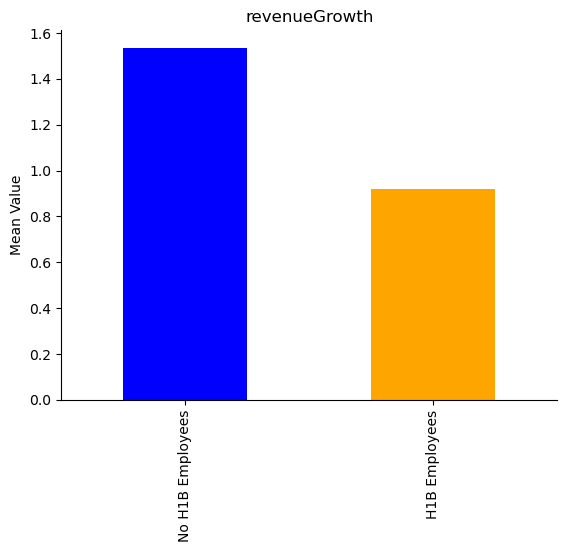

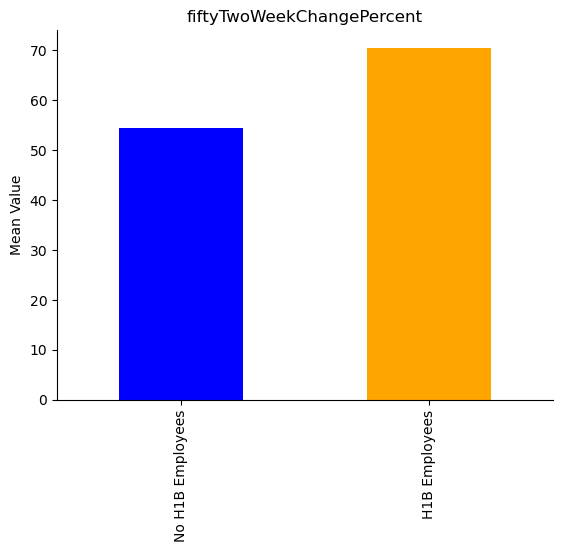

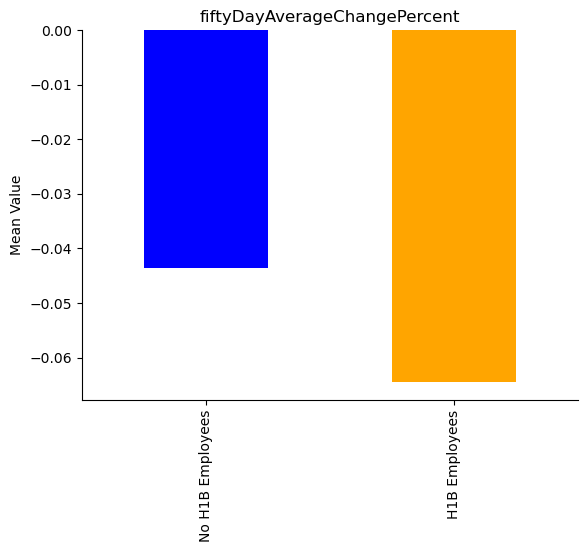

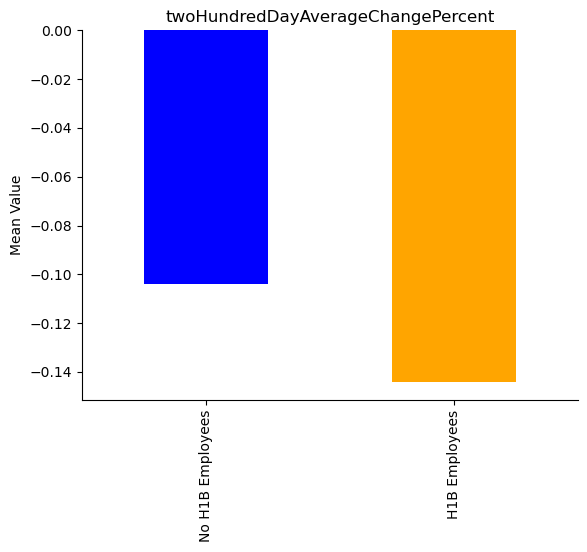

In [ ]:
group_means.index = ['No H1B Employees', 'H1B Employees']
colors = ['blue', 'orange'] 
for col in group_means.columns:
    group_means[col].plot(kind='bar', title=col, color=colors)
    plt.ylabel('Mean Value')
    sns.despine()
    plt.show()


In [192]:
group_medians = dv_numericals.groupby('visa').median()

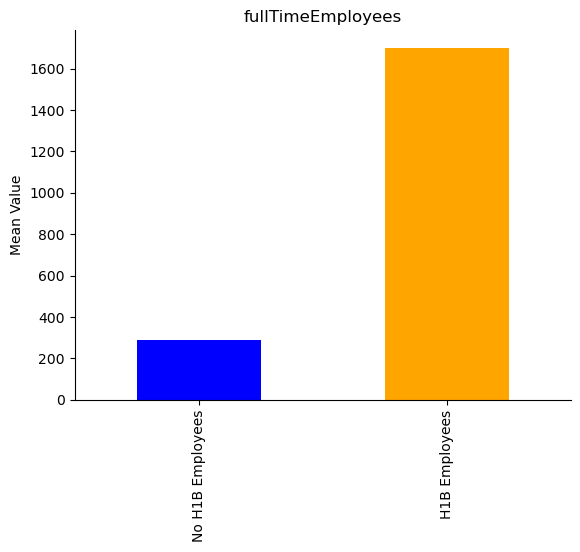

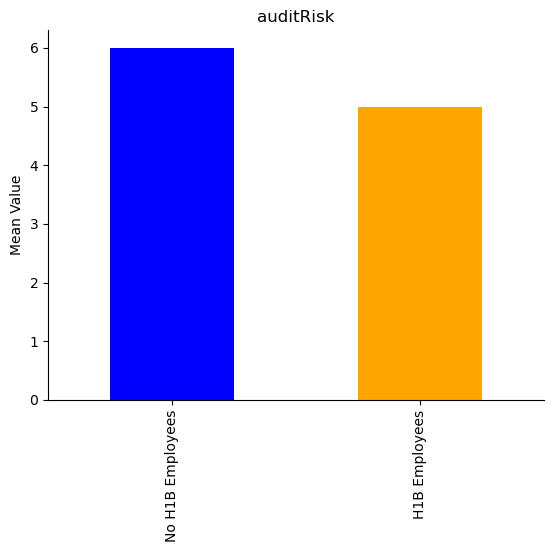

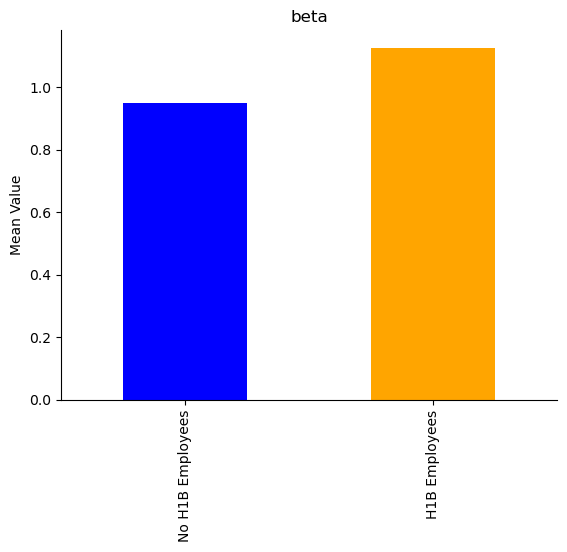

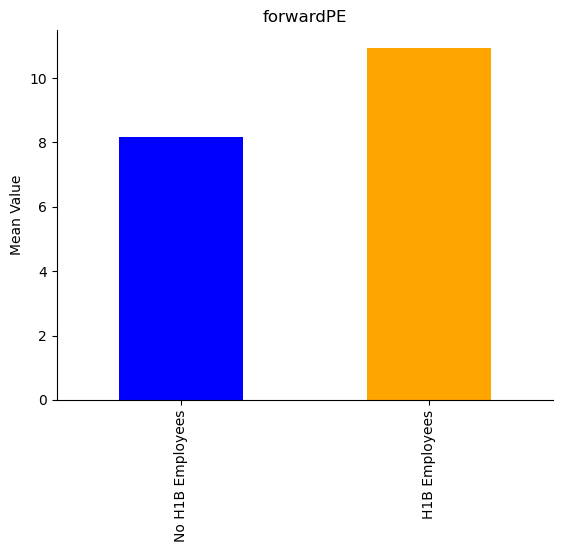

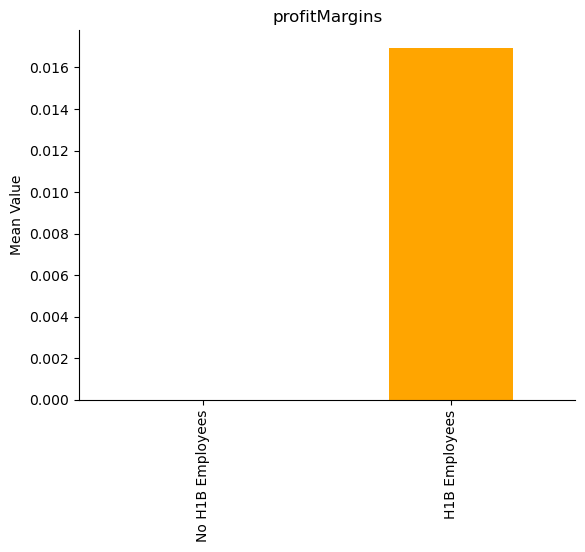

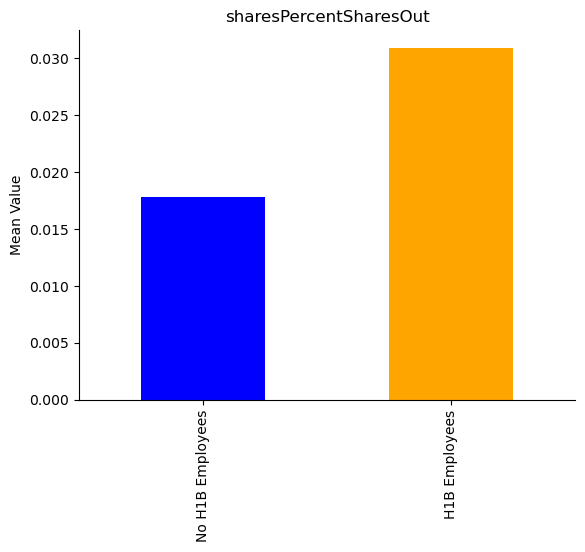

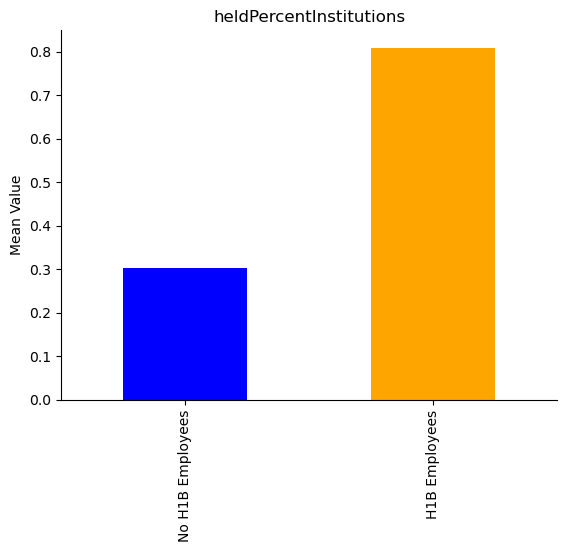

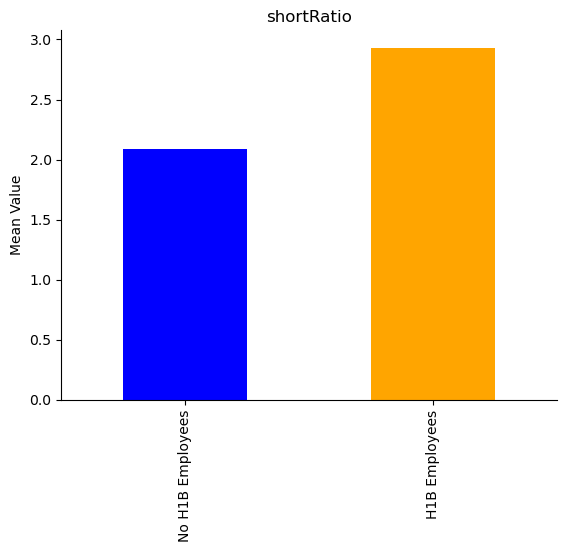

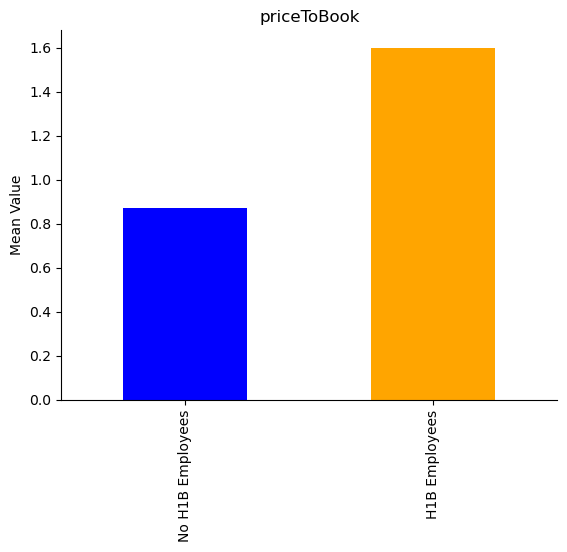

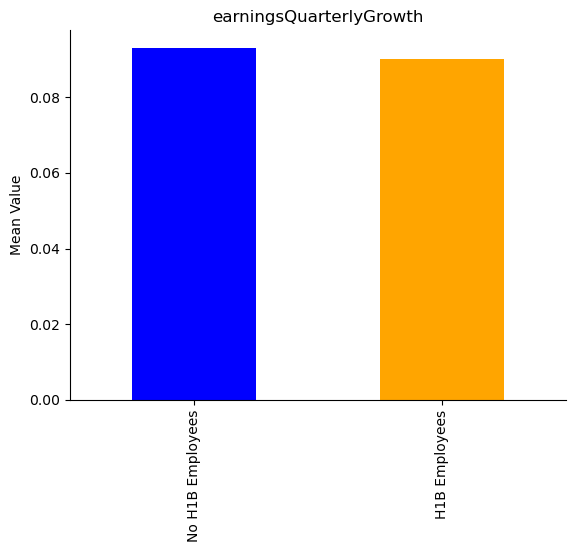

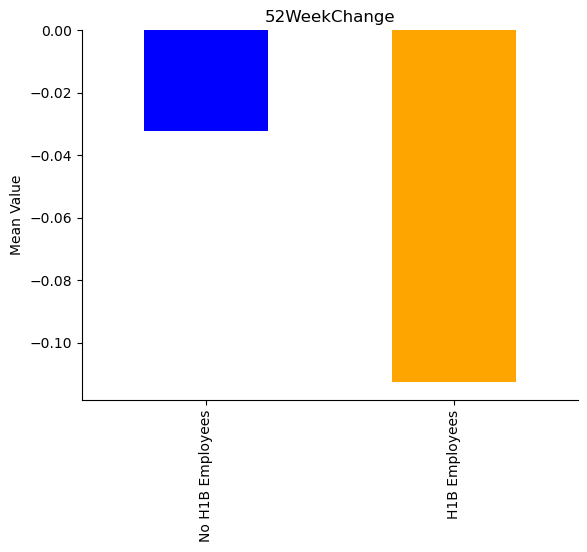

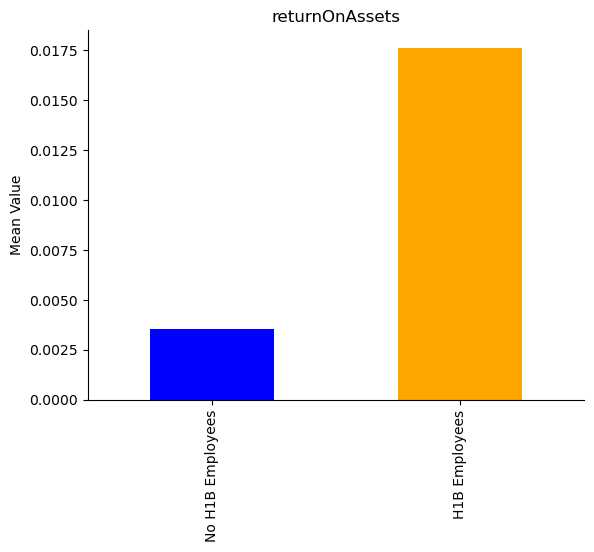

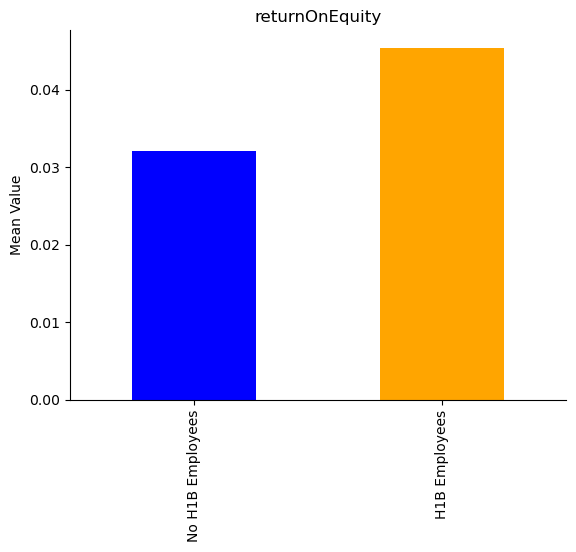

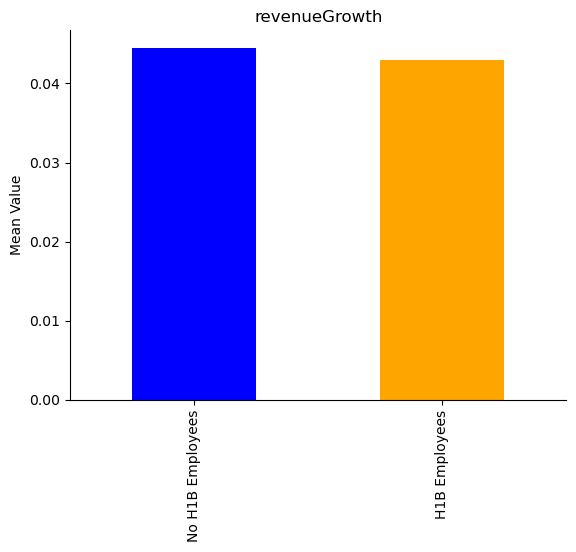

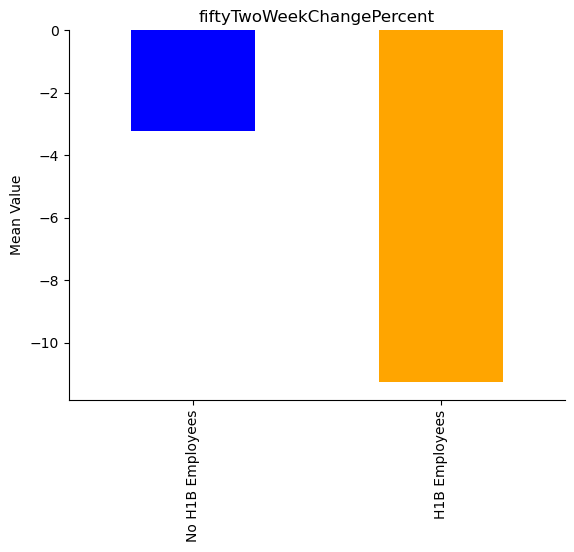

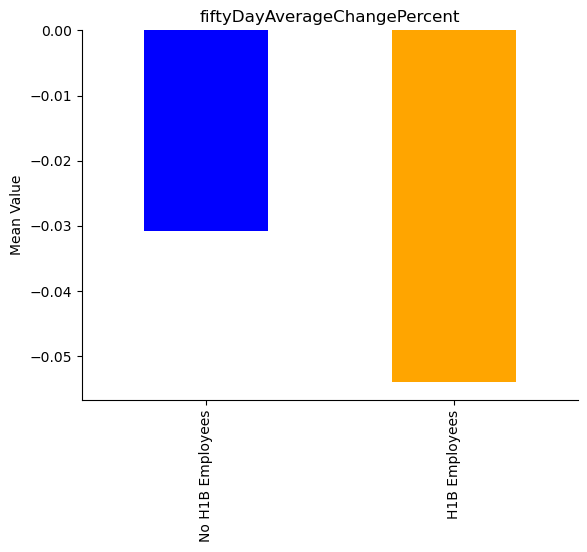

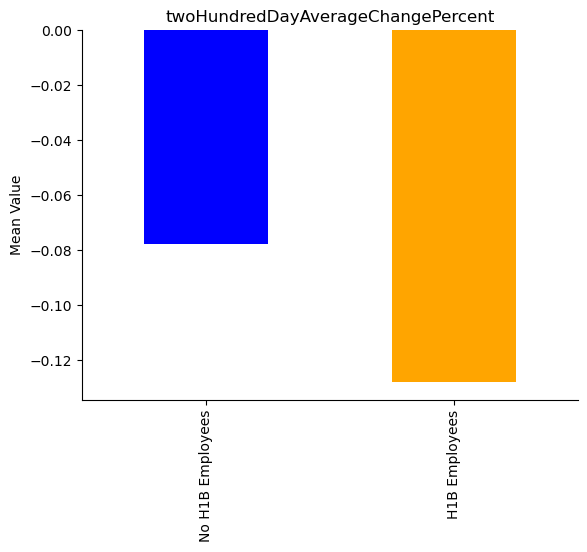

In [195]:
group_medians.index = ['No H1B Employees', 'H1B Employees']
for col in group_medians.columns:
    group_medians[col].plot(kind='bar', title=col, color=colors)
    plt.ylabel('Mean Value')
    sns.despine()
    plt.show()

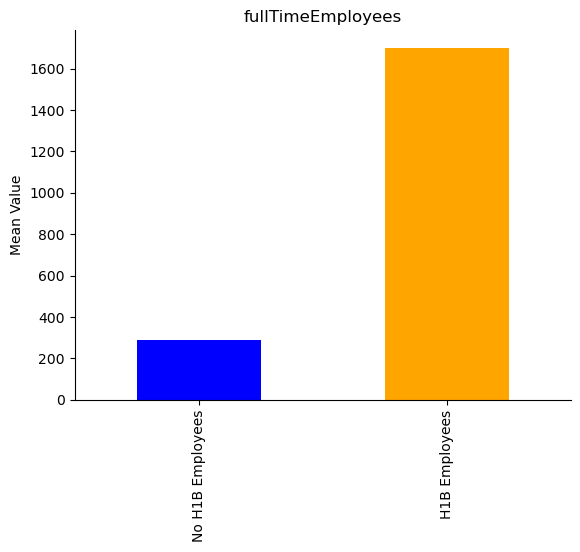

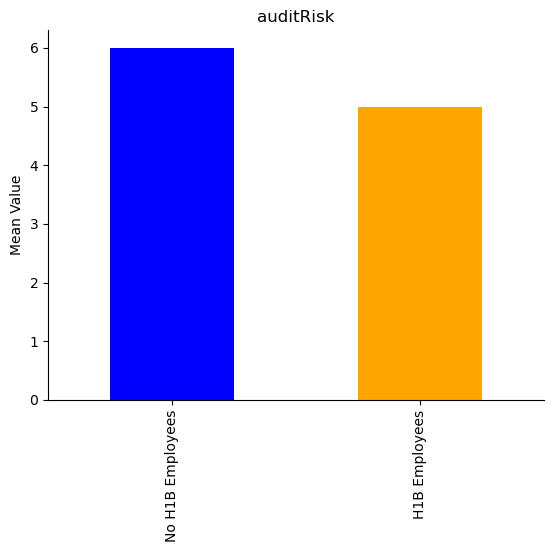

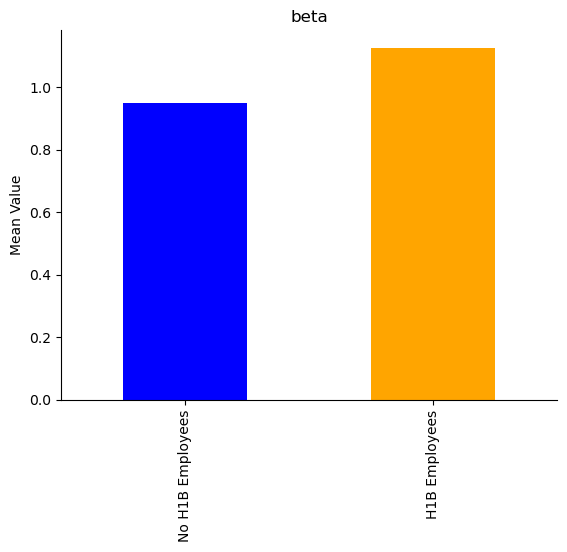

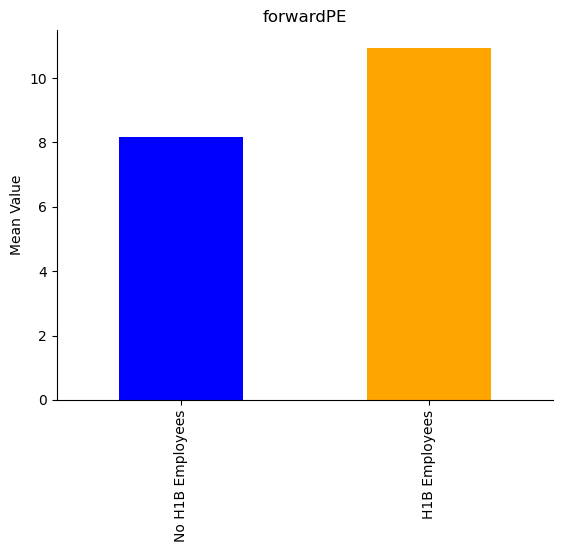

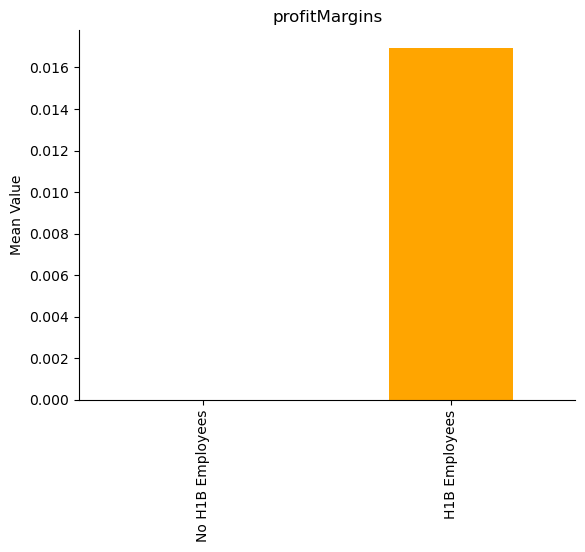

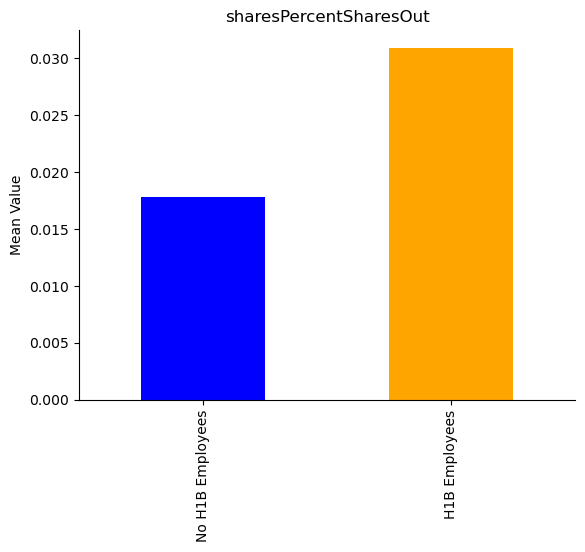

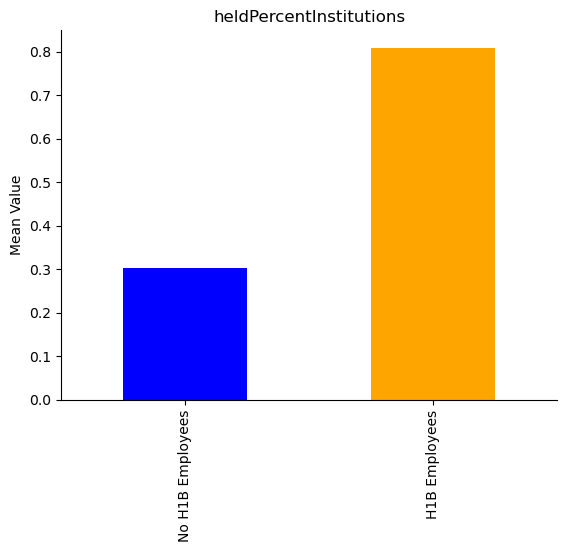

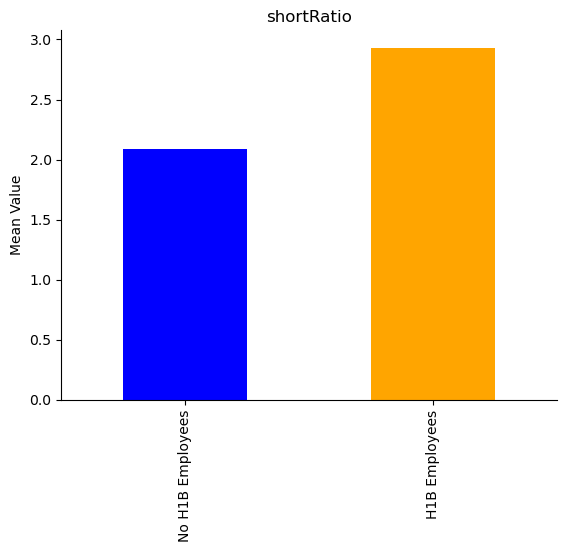

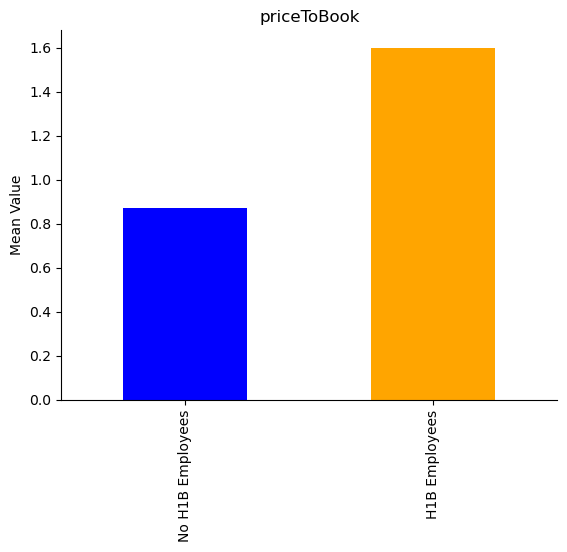

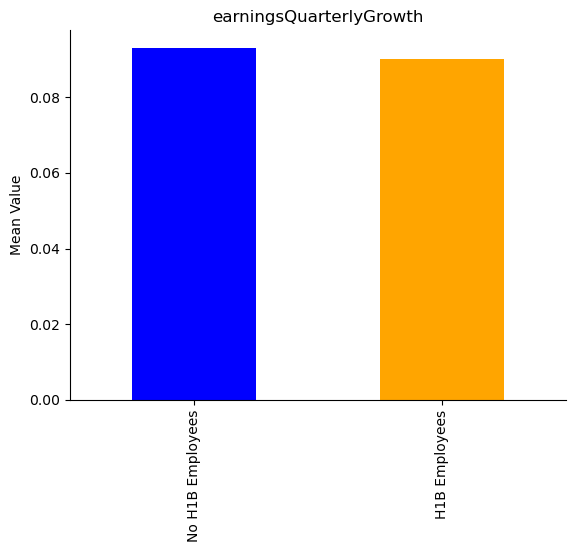

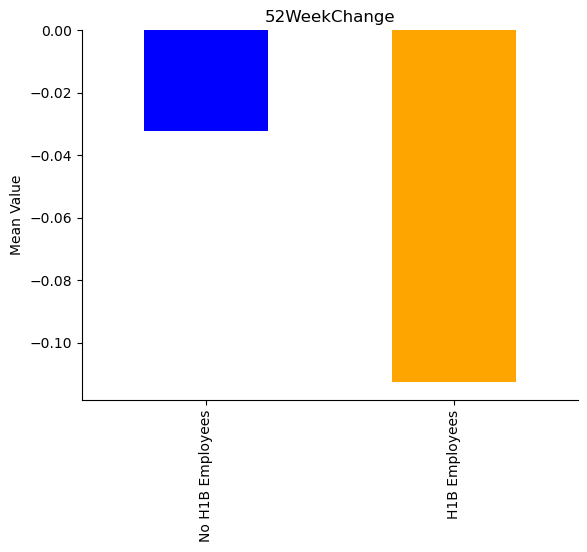

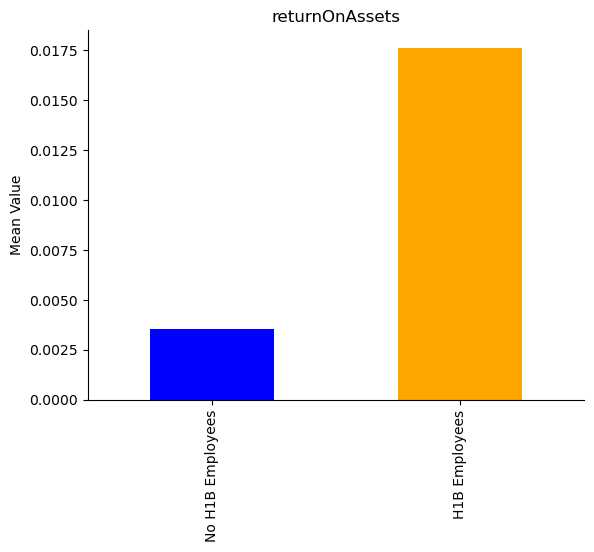

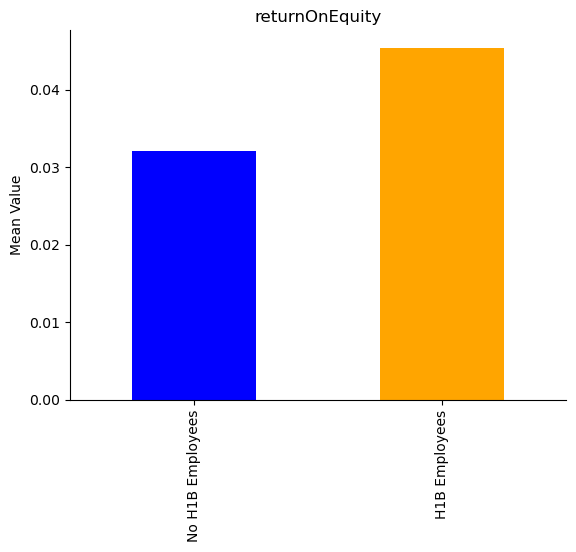

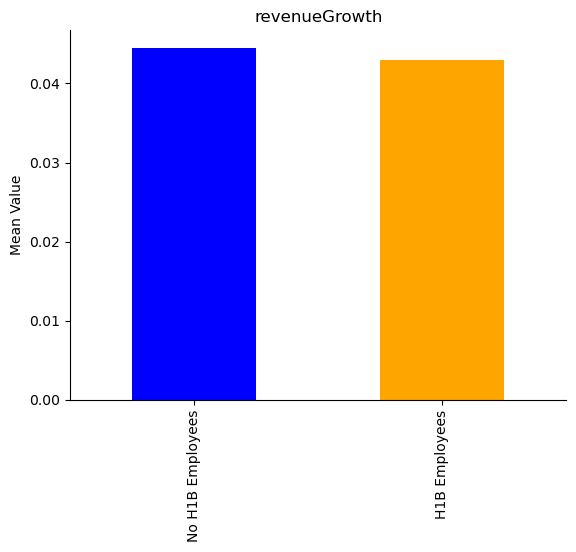

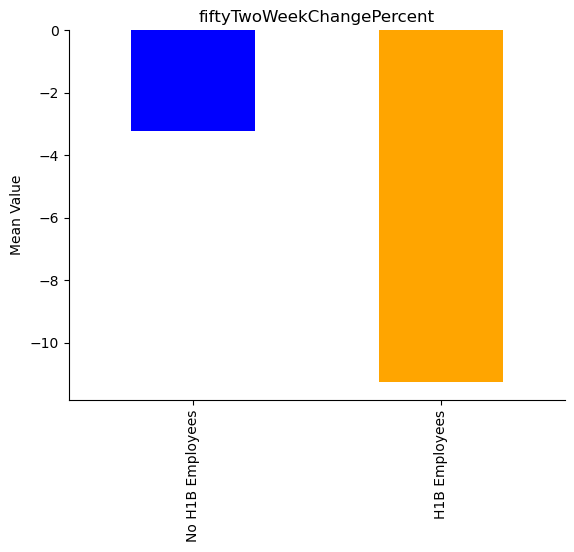

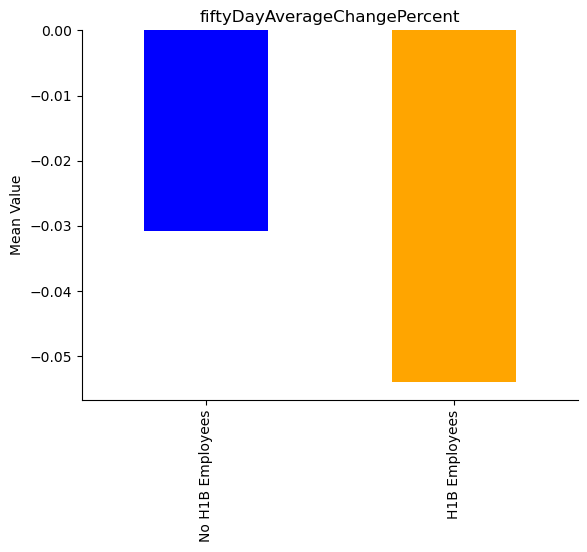

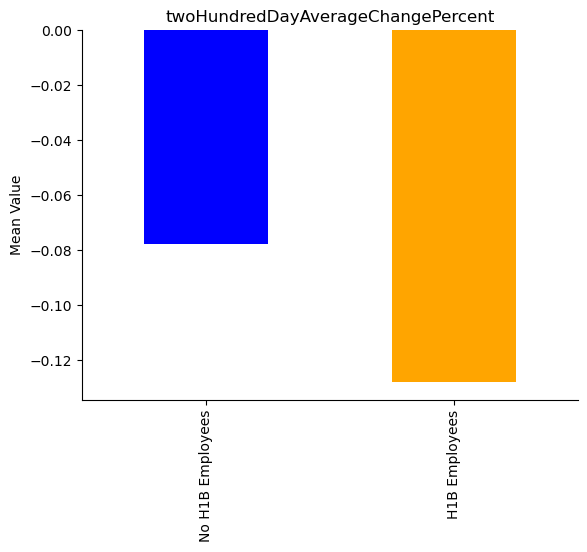

In [196]:
group_stds = dv_numericals.groupby('visa').std()
group_stds.index = ['No H1B Employees', 'H1B Employees']
for col in group_medians.columns:
    group_medians[col].plot(kind='bar', title=col, color=colors)
    plt.ylabel('Mean Value')
    sns.despine()
    plt.show()